# *Relaxation and Decoherence* 

This notebook provides a method of running circuits and measuring hardware parameters of the $T_1$ and $T_2$ decay times for 2 connected qubits. The method of parameter extraction is through solving a Markovian quantum master equation and minimising the least-squares regression between this solution and the experimental data. The notebook is split into two main segments, the experimental circuits and collection of data, followed by the numerical solutions.

## Initialisation Cell

In [1]:
# Plotting
import matplotlib.pyplot as plt
import matplotlib.pylab as pl

# Numerical
import jax
import numpy as np
import jax.numpy as jnp

from jax.numpy.linalg import multi_dot
from jax import jit, vmap, random, jacrev
# from jax.ops import index, index_add, index_update
from jax.experimental.ode import odeint
from numpy import sqrt
import pandas as pd

key = random.PRNGKey(42)

# Qiskit
import qiskit

from qiskit import IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.tools.visualization import *
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import U2Gate
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

provider = IBMQ.load_account()

# Constants and Units
from astropy import units as unts
from astropy import constants as cnts

# Extras
import warnings

warnings.filterwarnings("ignore")

# Shows a window in the upper left part with real-time information 
# on the status of the jobs running on the IBM Q device
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [2]:
jax.local_devices()

[CpuDevice(id=0)]

## Connect to IBMQ

In [3]:
IBMQ.get_provider(hub='ibm-q',
                  group='open',
                  project='main')
backend = provider.get_backend('ibmq_santiago')

Initialise our parameters

In [4]:
t1l = []
t2l = []

for i in range(len(backend.properties().qubits)):
    t1l.append(backend.properties().t1(i))
    t2l.append(backend.properties().t2(i))

In [5]:
q0err = backend.properties().readout_error(0)
print(q0err)
q1err = backend.properties().readout_error(1)
print(q1err)

0.0373
0.013900000000000023


In [6]:
backend_config = backend.configuration()
backend_prop = backend.properties()

hamiltonian = backend_config.hamiltonian
w0 = hamiltonian['vars']['wq0']
w1 = hamiltonian['vars']['wq1']
w2 = hamiltonian['vars']['wq2']
w3 = hamiltonian['vars']['wq3']
w4 = hamiltonian['vars']['wq4']
j01 = hamiltonian['vars']['jq0q1']
j12 = hamiltonian['vars']['jq1q2']
j23 = hamiltonian['vars']['jq2q3']
j34 = hamiltonian['vars']['jq3q4']

In [7]:
ygate_time = (backend.properties().gate_length('sx', 0) * 2 * unts.s).to(unts.ns)
ygate_time

<Quantity 71.11111111 ns>

In [8]:
qerr = np.sqrt(q0err ** 2 + q1err ** 2) / 2
qerr

0.01990288923749515

In [9]:
xgate_time = (backend.properties().gate_length('x', 0) * unts.s).to(unts.ns)
xgate_time

<Quantity 35.55555556 ns>

In [10]:
qiskit.circuit.library.YGate(0).decompositions[0].draw()

┌───────────────┐
q_0: ┤ U3(π,π/2,π/2) ├
     └───────────────┘

In [11]:
qiskit.circuit.library.U3Gate(np.pi, np.pi/2, np.pi/2).decompositions[0].draw()

/home/dean/.local/lib/python3.9/site-packages/qiskit/circuit/tools/pi_check.py:55: SymPyDeprecationWarning: 

The expr_free_symbols property is deprecated. Use free_symbols to get
the free symbols of an expression.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-expr-free-symbols
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  syms = expr.expr_free_symbols


┌─────────┐┌────┐┌────────┐┌────┐┌──────────┐
q_0: ┤ Rz(π/2) ├┤ √X ├┤ Rz(2π) ├┤ √X ├┤ Rz(7π/2) ├
     └─────────┘└────┘└────────┘└────┘└──────────┘

In [12]:
(backend.properties().gate_length('rz', 0) * unts.s).to(unts.ns)

<Quantity 0. ns>

In [13]:
qiskit.circuit.library.U2Gate(0, 0).decompositions[0].draw()

┌─────────────┐
q_0: ┤ U3(π/2,0,0) ├
     └─────────────┘

In [14]:
qiskit.circuit.library.U3Gate(np.pi/2, 0, 0).decompositions[0].draw()

global phase: 3π/2
     ┌───────┐┌────┐┌──────────┐┌────┐┌────────┐
q_0: ┤ Rz(0) ├┤ √X ├┤ Rz(3π/2) ├┤ √X ├┤ Rz(3π) ├
     └───────┘└────┘└──────────┘└────┘└────────┘

In [15]:
t2gatetime = 3 * ygate_time
t2gatetime.to(unts.us)

<Quantity 0.21333333 us>

In [16]:
dt = (backend_config.dt * unts.s).to(unts.ns)
dt

<Quantity 0.22222222 ns>

In [17]:
((4 * unts.us) / dt).to(unts.dimensionless_unscaled) * 2

<Quantity 36000.>

In [18]:
dt_times = np.linspace(0, 1332000, 75)
dt_times[:3]

array([    0., 18000., 36000.])

In [19]:
(dt_times[-3:] * dt).to(unts.us)

<Quantity [288., 292., 296.] us>

With some helper functions

In [20]:
def expt(T, w):
    """
    This function computes the average number of photons, n, depending on the frequency, w, and the temperature, T.
    Inputs:
    T - Temperature (in Kelvin)
    w - Frequency (in Hz)
    Outputs:
    n - Average photon number
    """
    n = 1/(jnp.exp((cnts.hbar.value * w)/(cnts.k_B.value * T)) - 1)
    return float(n)

In [21]:
def T(w, n):
    """
    This function computes the temperature, T, depending on the frequency, w, and the average number of photons, n.
    Inputs:
    T - Temperature (in Kelvin)
    n - Average photon number
    Outputs:
    w - Frequency (in Hz)
    """
    return cnts.hbar.value * w/(cnts.k_B.value * jnp.log(1/n + 1)) * unts.K

As well as some ansatze for the other parameters, based on the latest configuration $T_1$ & $T_2$ times and the claimed qubit temperatures of 15 mK.

In [22]:
n1 = expt(15e-3, w0)
n2 = expt(15e-3, w1)

t1c = jnp.array(t1l)
t2c = jnp.array(t2l)

g1l = 1/t1c
g2l = 1/t2c

## Generation of coherence circuits

This shows how to generate the circuits. The list of qubits specifies for which qubits to generate characterization circuits; these circuits will run in parallel. The discrete unit of time is the Delay gate, which instructs the circuit to do nothing for a specified amount of time.

In [23]:
time = np.linspace(0, 74*4, 75)
tie = np.linspace(0, 74, 75)

qubits = [0, 1]
shots = 8192

n = len(qubits)
N = 2 ** n

qr = qiskit.QuantumRegister(max(qubits)+1)
cr = qiskit.ClassicalRegister(len(qubits))

nosc = 5

osc_freq = nosc/time[-1]

In [24]:
cool = pl.cm.cool(np.linspace(0, 1, N))
plasma = pl.cm.plasma(np.linspace(0, 1, N + 1))
magma = pl.cm.magma(np.linspace(0, 1, N))
winter = pl.cm.winter(np.linspace(0, 1, N))

In [25]:
def pad_id_gates(circuit, qr, qubit, num_of_id_gates):
    """
    A function for padding a circuit with single-qubit delay gates.
    Args:
        circuit (QuantumCircuit): the quantum circuit that the gates should be
            appended to
        qr (QuantumRegister): the qubit register where the gates should be added
        qubit (int): index of qubit where the gates should be added
        num_of_id_gates (int): the number of delay gates to add
    Returns:
        circuit: The original circuit object, but with delay
            gates added to the qubit register qr at qubit 'qubit'
    """
    
    circuit.barrier(qr[qubit])
    num_of_id_gates = int(num_of_id_gates)
    circuit.delay(num_of_id_gates, qr[qubit], unit = 'dt')

    circuit.barrier(qr[qubit])
    return circuit

In [26]:
qiskit.circuit.Delay(10, unit='dt')

Delay(duration=10[unit=dt])

### T1 Circuits

In [27]:
t1circuits = []

for circ_index, circ_length in enumerate(dt_times):
    circ = qiskit.QuantumCircuit(qr, cr)
    circ.name = 't1circuit_' + str(circ_index) + '_0'
    for _, qubit in enumerate(qubits):
        circ.x(qr[qubit])
        circ = pad_id_gates(circ, qr, qubit, circ_length)
    # circ.barrier(qr)
    for qind, qubit in enumerate(qubits):
        circ.measure(qr[qubit], cr[qind])
    t1circuits.append(circ)

In [28]:
t1circuits[-1].draw()

┌───┐ ░ ┌────────────────────┐ ░ ┌─┐   
q0_0: ┤ X ├─░─┤ Delay(1332000[dt]) ├─░─┤M├───
      ├───┤ ░ ├────────────────────┤ ░ └╥┘┌─┐
q0_1: ┤ X ├─░─┤ Delay(1332000[dt]) ├─░──╫─┤M├
      └───┘ ░ └────────────────────┘ ░  ║ └╥┘
c0: 2/══════════════════════════════════╩══╩═
                                        0  1

### T2* Circuits

In [29]:
t2scircuits = []

for circ_index, circ_length in enumerate(dt_times):
    circ = qiskit.QuantumCircuit(qr, cr)
    circ.name = 't2starcircuit_' + str(circ_index) + '_0'
    for qind, qubit in enumerate(qubits):
        circ.h(qr[qubit])
        circ = pad_id_gates(circ, qr, qubit, circ_length)
        # circ.append(U1Gate(2*np.pi*osc_freq*time[circ_index]), [qr[qubit]])
        circ.h(qr[qubit])
    circ.barrier(qr)
    for qind, qubit in enumerate(qubits):
        circ.measure(qr[qubit], cr[qind])
    t2scircuits.append(circ)

In [30]:
t2scircuits[-1].draw()

┌───┐ ░ ┌────────────────────┐ ░ ┌───┐ ░ ┌─┐   
q0_0: ┤ H ├─░─┤ Delay(1332000[dt]) ├─░─┤ H ├─░─┤M├───
      ├───┤ ░ ├────────────────────┤ ░ ├───┤ ░ └╥┘┌─┐
q0_1: ┤ H ├─░─┤ Delay(1332000[dt]) ├─░─┤ H ├─░──╫─┤M├
      └───┘ ░ └────────────────────┘ ░ └───┘ ░  ║ └╥┘
c0: 2/══════════════════════════════════════════╩══╩═
                                                0  1

In [31]:
t2ccircuits = []

for circ_index, circ_length in enumerate(dt_times):
    circ = qiskit.QuantumCircuit(qr, cr)
    circ.name = 't2starcircuit_' + str(circ_index) + '_0'
    circ.h(qr[qubits[0]])
    circ.id(qr[qubits[1]])
    for qind, qubit in enumerate(qubits):
        circ = pad_id_gates(circ, qr, qubit, circ_length)
        # circ.append(U1Gate(2*np.pi*osc_freq*time[circ_index]), [qr[qubit]])
    circ.h(qr[qubits[0]])
    circ.id(qr[qubits[1]])
    circ.barrier(qr)
    for qind, qubit in enumerate(qubits):
        circ.measure(qr[qubit], cr[qind])
    t2ccircuits.append(circ)

In [32]:
t2ccircuits[-1].draw()

┌───┐ ░ ┌────────────────────┐ ░ ┌───┐ ░ ┌─┐   
q0_0: ┤ H ├─░─┤ Delay(1332000[dt]) ├─░─┤ H ├─░─┤M├───
      ├───┤ ░ ├────────────────────┤ ░ ├───┤ ░ └╥┘┌─┐
q0_1: ┤ I ├─░─┤ Delay(1332000[dt]) ├─░─┤ I ├─░──╫─┤M├
      └───┘ ░ └────────────────────┘ ░ └───┘ ░  ║ └╥┘
c0: 2/══════════════════════════════════════════╩══╩═
                                                0  1

In [33]:
t2hcircuits = []

for circ_index, circ_length in enumerate(dt_times):
    circ = qiskit.QuantumCircuit(qr, cr)
    circ.name = 't2starcircuit_' + str(circ_index) + '_0'
    circ.h(qr[qubits[0]])
    circ.x(qr[qubits[1]])
    for qind, qubit in enumerate(qubits):
        circ = pad_id_gates(circ, qr, qubit, circ_length)
        # circ.append(U1Gate(2*np.pi*osc_freq*time[circ_index]), [qr[qubit]])
    circ.h(qr[qubits[0]])
    circ.id(qr[qubits[1]])
    circ.barrier(qr)
    for qind, qubit in enumerate(qubits):
        circ.measure(qr[qubit], cr[qind])
    t2hcircuits.append(circ)

In [34]:
t2hcircuits[-1].draw()

┌───┐ ░ ┌────────────────────┐ ░ ┌───┐ ░ ┌─┐   
q0_0: ┤ H ├─░─┤ Delay(1332000[dt]) ├─░─┤ H ├─░─┤M├───
      ├───┤ ░ ├────────────────────┤ ░ ├───┤ ░ └╥┘┌─┐
q0_1: ┤ X ├─░─┤ Delay(1332000[dt]) ├─░─┤ I ├─░──╫─┤M├
      └───┘ ░ └────────────────────┘ ░ └───┘ ░  ║ └╥┘
c0: 2/══════════════════════════════════════════╩══╩═
                                                0  1

### T2 Circuits

In [35]:
def t2_circuits(time, qubits, n_echos, phase_alt_echo):
    
    if n_echos < 1:
        raise ValueError('Must be at least one echo')

    xdata = 2 * np.array(time) * n_echos

    qr = qiskit.QuantumRegister(max(qubits)+1)
    cr = qiskit.ClassicalRegister(len(qubits))

    circuits = []

    for circ_index, circ_length in enumerate(time):
        circ = qiskit.QuantumCircuit(qr, cr)
        circ.name = 't2circuit_' + str(circ_index) + '_0'
        for qind, qubit in enumerate(qubits):

            # First Y90 and Y echo
            circ.append(U2Gate(0.0, 0.0), [qr[qubit]])  # Y90
            circ = pad_id_gates(circ, qr, qubit, circ_length)  # ids
            circ.y(qr[qubit])

            for echoid in range(n_echos-1):  # repeat
                circ = pad_id_gates(circ, qr, qubit, 2*circ_length)  # ids
                if phase_alt_echo and (not echoid % 2):  # optionally
                    circ.x(qr[qubit])  # X
                else:
                    circ.y(qr[qubit])

            circ = pad_id_gates(circ, qr, qubit, circ_length)  # ids
            circ.append(U2Gate(0.0, 0.0), [qr[qubit]])  # Y90
        circ.barrier(qr)
        for qind, qubit in enumerate(qubits):
            circ.measure(qr[qubit], cr[qind])  # measure
        circuits.append(circ)

    return circuits

In [36]:
# Echo Circuits
t2ecircuits = t2_circuits(jnp.floor(dt_times).astype(int), qubits, n_echos = 1, phase_alt_echo = False)

In [37]:
t2ecircuits[-1].draw()

┌─────────┐ ░ ┌────────────────────┐ ░ ┌───┐ ░ ┌────────────────────┐ ░ »
q1_0: ┤ U2(0,0) ├─░─┤ Delay(1332000[dt]) ├─░─┤ Y ├─░─┤ Delay(1332000[dt]) ├─░─»
      ├─────────┤ ░ ├────────────────────┤ ░ ├───┤ ░ ├────────────────────┤ ░ »
q1_1: ┤ U2(0,0) ├─░─┤ Delay(1332000[dt]) ├─░─┤ Y ├─░─┤ Delay(1332000[dt]) ├─░─»
      └─────────┘ ░ └────────────────────┘ ░ └───┘ ░ └────────────────────┘ ░ »
c1: 2/════════════════════════════════════════════════════════════════════════»
                                                                              »
«      ┌─────────┐ ░ ┌─┐   
«q1_0: ┤ U2(0,0) ├─░─┤M├───
«      ├─────────┤ ░ └╥┘┌─┐
«q1_1: ┤ U2(0,0) ├─░──╫─┤M├
«      └─────────┘ ░  ║ └╥┘
«c1: 2/═══════════════╩══╩═
«                     0  1

### Readout Error Mitigation

In [38]:
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubits, qr=qr, circlabel='mcal')

## Backend Execution

In [39]:
# Run the Readout Error Mitigation circuits
cal_results = qiskit.execute(meas_calibs, backend = backend, shots = shots).result()

In [40]:
# Run the T1 circuits
t1_backend_result = qiskit.execute(t1circuits, backend, shots = shots, optimization_level = 0).result()

In [41]:
# Run the T2* circuits
t2star_backend_result = qiskit.execute(t2scircuits, backend, shots = shots, optimization_level = 0).result()

In [42]:
# Run the T2 Echo circuits
t2e_backend_result = qiskit.execute(t2ecircuits, backend, shots = shots, optimization_level = 0).result()

In [43]:
# Run the T2 CPMG circuits
t2c_backend_result = qiskit.execute(t2ccircuits, backend, shots = shots, optimization_level = 0).result()

In [44]:
# Run the T2 Hahn circuits
t2h_backend_result = qiskit.execute(t2hcircuits, backend, shots = shots, optimization_level = 0).result()

Let's look at the calibration results

Average Measurement Fidelity: 0.951050


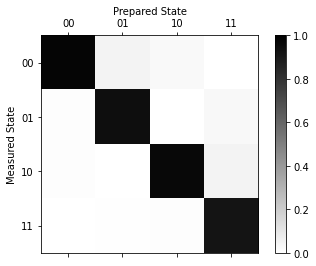

In [45]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel = 'mcal')
print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity())
meas_fitter.plot_calibration()

Apply the error mitigation

In [46]:
# Results without mitigation
t1_raw_counts = t1_backend_result.get_counts(0)
t2s_raw_counts = t2star_backend_result.get_counts(0)
t2e_raw_counts = t2e_backend_result.get_counts(0)
t2c_raw_counts = t2c_backend_result.get_counts(0)
t2h_raw_counts = t2h_backend_result.get_counts(0)

# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation

t1_mitigated_results = meas_filter.apply(t1_backend_result)
t2s_mitigated_results = meas_filter.apply(t2star_backend_result)
t2e_mitigated_results = meas_filter.apply(t2e_backend_result)
t2c_mitigated_results = meas_filter.apply(t2c_backend_result)
t2h_mitigated_results = meas_filter.apply(t2h_backend_result)

t1_mitigated_counts = t1_mitigated_results.get_counts(0)
t2s_mitigated_counts = t2s_mitigated_results.get_counts(0)
t2e_mitigated_counts = t2e_mitigated_results.get_counts(0)
t2c_mitigated_counts = t2c_mitigated_results.get_counts(0)
t2h_mitigated_counts = t2h_mitigated_results.get_counts(0)

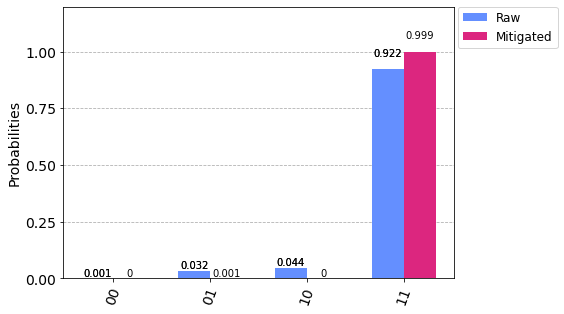

In [47]:
# T1 Mitigated Counts
plot_histogram([t1_raw_counts, t1_mitigated_counts], legend = ['Raw', 'Mitigated'])

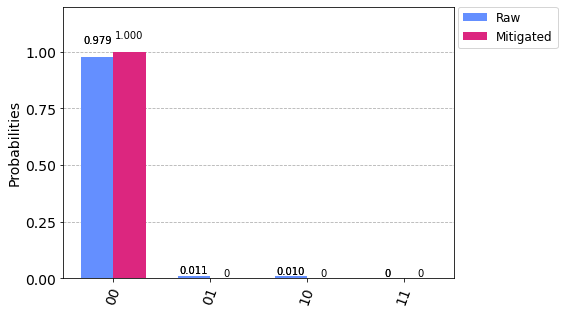

In [48]:
# T2* Mitigated Counts
plot_histogram([t2s_raw_counts, t2s_mitigated_counts], legend = ['Raw', 'Mitigated'])

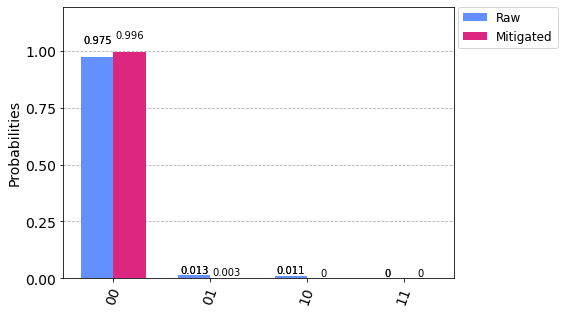

In [49]:
# T2 Echo Mitigated Counts
plot_histogram([t2e_raw_counts, t2e_mitigated_counts], legend = ['Raw', 'Mitigated'])

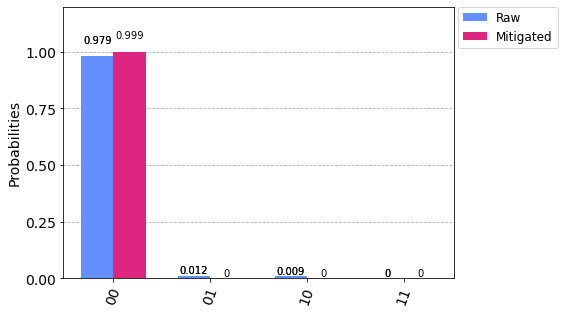

In [50]:
# T2 CPMG Mitigated Counts
plot_histogram([t2c_raw_counts, t2c_mitigated_counts], legend = ['Raw', 'Mitigated'])

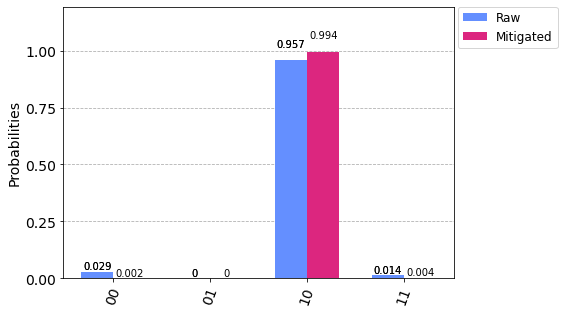

In [51]:
# T2 Hahn Mitigated Counts
plot_histogram([t2h_raw_counts, t2h_mitigated_counts], legend = ['Raw', 'Mitigated'])

## Data Fitting

In [52]:
# T1 Raw

t1raw_lst00 = []
t1raw_lst01 = []
t1raw_lst10 = []
t1raw_lst11 = []

t1ystd00 = []
t1ystd01 = []
t1ystd10 = []
t1ystd11 = []

for i in range(len(time)):
    if '11' in t1_backend_result.get_counts(i):
        i11 = t1_backend_result.get_counts(i)['11']
    else:
        i11 = 0
    if '10' in t1_backend_result.get_counts(i):
        i10 = t1_backend_result.get_counts(i)['10']
    else:
        i10 = 0
    if '01' in t1_backend_result.get_counts(i):
        i01 = t1_backend_result.get_counts(i)['01']
    else:
        i01 = 0
    if '00' in t1_backend_result.get_counts(i):
        i00 = t1_backend_result.get_counts(i)['00']
    else:
        i00 = 0
    
    q00 = i00/shots
    q01 = i01/shots
    q10 = i10/shots
    q11 = i11/shots
    
    q0err
    q1err
    
    t1ystd00.append(np.sqrt(q00 * (1-q00) / shots) + (2 * q0err * q00))
    t1ystd01.append(np.sqrt(q01 * (1-q01) / shots) + (q0err + q1err) * q01)
    t1ystd10.append(np.sqrt(q10 * (1-q10) / shots) + (q1err + q0err) * q10)
    t1ystd11.append(np.sqrt(q11 * (1-q11) / shots) + (2 * q1err * q11))
    
    t1raw_lst00.append(q00)
    t1raw_lst01.append(q01)
    t1raw_lst10.append(q10)
    t1raw_lst11.append(q11)

In [53]:
# T1 Mitigated

t1mit_lst00 = []
t1mit_lst01 = []
t1mit_lst10 = []
t1mit_lst11 = []

for i in range(len(time)):
    if '11' in t1_mitigated_results.get_counts(i):
        i11 = t1_mitigated_results.get_counts(i)['11']
    else:
        i11 = 0
    if '10' in t1_mitigated_results.get_counts(i):
        i10 = t1_mitigated_results.get_counts(i)['10']
    else:
        i10 = 0
    if '01' in t1_mitigated_results.get_counts(i):
        i01 = t1_mitigated_results.get_counts(i)['01']
    else:
        i01 = 0
    if '00' in t1_mitigated_results.get_counts(i):
        i00 = t1_mitigated_results.get_counts(i)['00']
    else:
        i00 = 0
    
    q00 = i00/shots
    q01 = i01/shots
    q10 = i10/shots
    q11 = i11/shots
    
    t1mit_lst00.append(q00)
    t1mit_lst01.append(q01)
    t1mit_lst10.append(q10)
    t1mit_lst11.append(q11)

In [54]:
# IBMQ Experiments take long in queues, this is old data from thesis/paper

# t1mit_lst00 = pd.read_csv('./Q2_T1_i11_raw00.csv',
#                           delimiter=',', header=None).transpose().iloc[1].to_list()
# t1mit_lst01 = pd.read_csv('./Q2_T1_i11_raw01.csv',
#                           delimiter=',', header=None).transpose().iloc[1].to_list()
# t1mit_lst10 = pd.read_csv('./Q2_T1_i11_raw10.csv',
#                           delimiter=',', header=None).transpose().iloc[1].to_list()
# t1mit_lst11 = pd.read_csv('./Q2_T1_i11_raw11.csv',
#                           delimiter=',', header=None).transpose().iloc[1].to_list()

In [55]:
# T2* Raw

t2sraw_lst00 = []
t2sraw_lst01 = []
t2sraw_lst10 = []
t2sraw_lst11 = []

for i in range(len(time)):
    if '00' in t2star_backend_result.get_counts(i):
        i00 = t2star_backend_result.get_counts(i)['00']
    else:
        i00 = 0
    if '01' in t2star_backend_result.get_counts(i):
        i01 = t2star_backend_result.get_counts(i)['01']
    else:
        i01 = 0
    if '10' in t2star_backend_result.get_counts(i):
        i10 = t2star_backend_result.get_counts(i)['10']
    else:
        i10 = 0
    if '11' in t2star_backend_result.get_counts(i):
        i11 = t2star_backend_result.get_counts(i)['11']
    else:
        i11 = 0
    
    q00 = i00/shots
    q01 = i01/shots
    q10 = i10/shots
    q11 = i11/shots
    
    t2sraw_lst00.append(q00)
    t2sraw_lst01.append(q01)
    t2sraw_lst10.append(q10)
    t2sraw_lst11.append(q11)

In [56]:
# T2* Mitigated

t2smit_lst00 = []
t2smit_lst01 = []
t2smit_lst10 = []
t2smit_lst11 = []

for i in range(len(time)):
    if '00' in t2s_mitigated_results.get_counts(i):
        i00 = t2s_mitigated_results.get_counts(i)['00']
    else:
        i00 = 0
    if '01' in t2s_mitigated_results.get_counts(i):
        i01 = t2s_mitigated_results.get_counts(i)['01']
    else:
        i01 = 0
    if '10' in t2s_mitigated_results.get_counts(i):
        i10 = t2s_mitigated_results.get_counts(i)['10']
    else:
        i10 = 0
    if '11' in t2s_mitigated_results.get_counts(i):
        i11 = t2s_mitigated_results.get_counts(i)['11']
    else:
        i11 = 0
    
    q00 = i00/shots
    q01 = i01/shots
    q10 = i10/shots
    q11 = i11/shots
    
    t2smit_lst00.append(q00)
    t2smit_lst01.append(q01)
    t2smit_lst10.append(q10)
    t2smit_lst11.append(q11)

In [57]:
# T2E Raw

t2eraw_lst00 = []
t2eraw_lst01 = []
t2eraw_lst10 = []
t2eraw_lst11 = []

for i in range(len(time)):
    if '00' in t2e_backend_result.get_counts(i):
        i00 = t2e_backend_result.get_counts(i)['00']
    else:
        i00 = 0
    if '01' in t2e_backend_result.get_counts(i):
        i01 = t2e_backend_result.get_counts(i)['01']
    else:
        i01 = 0
    if '10' in t2e_backend_result.get_counts(i):
        i10 = t2e_backend_result.get_counts(i)['10']
    else:
        i10 = 0
    if '11' in t2e_backend_result.get_counts(i):
        i11 = t2e_backend_result.get_counts(i)['11']
    else:
        i11 = 0
    
    q00 = i00/shots
    q01 = i01/shots
    q10 = i10/shots
    q11 = i11/shots
    
    t2eraw_lst00.append(q00)
    t2eraw_lst01.append(q01)
    t2eraw_lst10.append(q10)
    t2eraw_lst11.append(q11)

In [58]:
# T2E Mitigated

t2emit_lst00 = []
t2emit_lst01 = []
t2emit_lst10 = []
t2emit_lst11 = []

for i in range(len(time)):
    if '00' in t2e_mitigated_results.get_counts(i):
        i00 = t2e_mitigated_results.get_counts(i)['00']
    else:
        i00 = 0
    if '01' in t2e_mitigated_results.get_counts(i):
        i01 = t2e_mitigated_results.get_counts(i)['01']
    else:
        i01 = 0
    if '10' in t2e_mitigated_results.get_counts(i):
        i10 = t2e_mitigated_results.get_counts(i)['10']
    else:
        i10 = 0
    if '11' in t2e_mitigated_results.get_counts(i):
        i11 = t2e_mitigated_results.get_counts(i)['11']
    else:
        i11 = 0
    
    q00 = i00/shots
    q01 = i01/shots
    q10 = i10/shots
    q11 = i11/shots
    
    t2emit_lst00.append(q00)
    t2emit_lst01.append(q01)
    t2emit_lst10.append(q10)
    t2emit_lst11.append(q11)

In [59]:
# T2 CPMG Raw

t2craw_lst00 = []
t2craw_lst01 = []
t2craw_lst10 = []
t2craw_lst11 = []

for i in range(len(time)):
    if '00' in t2c_backend_result.get_counts(i):
        i00 = t2c_backend_result.get_counts(i)['00']
    else:
        i00 = 0
    if '01' in t2c_backend_result.get_counts(i):
        i01 = t2c_backend_result.get_counts(i)['01']
    else:
        i01 = 0
    if '10' in t2c_backend_result.get_counts(i):
        i10 = t2c_backend_result.get_counts(i)['10']
    else:
        i10 = 0
    if '11' in t2c_backend_result.get_counts(i):
        i11 = t2c_backend_result.get_counts(i)['11']
    else:
        i11 = 0
    
    q00 = i00/shots
    q01 = i01/shots
    q10 = i10/shots
    q11 = i11/shots
    
    t2craw_lst00.append(q00)
    t2craw_lst01.append(q01)
    t2craw_lst10.append(q10)
    t2craw_lst11.append(q11)

In [60]:
# T2 CPMG Mitigated

t2cmit_lst00 = []
t2cmit_lst01 = []
t2cmit_lst10 = []
t2cmit_lst11 = []

for i in range(len(time)):
    if '00' in t2c_mitigated_results.get_counts(i):
        i00 = t2c_mitigated_results.get_counts(i)['00']
    else:
        i00 = 0
    if '01' in t2c_mitigated_results.get_counts(i):
        i01 = t2c_mitigated_results.get_counts(i)['01']
    else:
        i01 = 0
    if '10' in t2c_mitigated_results.get_counts(i):
        i10 = t2c_mitigated_results.get_counts(i)['10']
    else:
        i10 = 0
    if '11' in t2c_mitigated_results.get_counts(i):
        i11 = t2c_mitigated_results.get_counts(i)['11']
    else:
        i11 = 0
    
    q00 = i00/shots
    q01 = i01/shots
    q10 = i10/shots
    q11 = i11/shots
    
    t2cmit_lst00.append(q00)
    t2cmit_lst01.append(q01)
    t2cmit_lst10.append(q10)
    t2cmit_lst11.append(q11)

In [61]:
# T2 Hahn Raw

t2hraw_lst00 = []
t2hraw_lst01 = []
t2hraw_lst10 = []
t2hraw_lst11 = []

for i in range(len(time)):
    if '00' in t2h_backend_result.get_counts(i):
        i00 = t2h_backend_result.get_counts(i)['00']
    else:
        i00 = 0
    if '01' in t2h_backend_result.get_counts(i):
        i01 = t2h_backend_result.get_counts(i)['01']
    else:
        i01 = 0
    if '10' in t2h_backend_result.get_counts(i):
        i10 = t2h_backend_result.get_counts(i)['10']
    else:
        i10 = 0
    if '11' in t2h_backend_result.get_counts(i):
        i11 = t2h_backend_result.get_counts(i)['11']
    else:
        i11 = 0
    
    q00 = i00/shots
    q01 = i01/shots
    q10 = i10/shots
    q11 = i11/shots
    
    t2hraw_lst00.append(q00)
    t2hraw_lst01.append(q01)
    t2hraw_lst10.append(q10)
    t2hraw_lst11.append(q11)

In [62]:
# T2 Hahn Mitigated

t2hmit_lst00 = []
t2hmit_lst01 = []
t2hmit_lst10 = []
t2hmit_lst11 = []

for i in range(len(time)):
    if '00' in t2h_mitigated_results.get_counts(i):
        i00 = t2h_mitigated_results.get_counts(i)['00']
    else:
        i00 = 0
    if '01' in t2h_mitigated_results.get_counts(i):
        i01 = t2h_mitigated_results.get_counts(i)['01']
    else:
        i01 = 0
    if '10' in t2h_mitigated_results.get_counts(i):
        i10 = t2h_mitigated_results.get_counts(i)['10']
    else:
        i10 = 0
    if '11' in t2h_mitigated_results.get_counts(i):
        i11 = t2h_mitigated_results.get_counts(i)['11']
    else:
        i11 = 0
    
    q00 = i00/shots
    q01 = i01/shots
    q10 = i10/shots
    q11 = i11/shots
    
    t2hmit_lst00.append(q00)
    t2hmit_lst01.append(q01)
    t2hmit_lst10.append(q10)
    t2hmit_lst11.append(q11)

In [63]:
# IBMQ Experiments take long in queues, this is old data from thesis/paper

# t2hmit_lst00 = pd.read_csv('./Q2_T2HX_raw00.csv',
#                           delimiter=',', header=None).transpose().iloc[1].to_list()
# t2hmit_lst01 = pd.read_csv('./Q2_T2HX_raw01.csv',
#                           delimiter=',', header=None).transpose().iloc[1].to_list()
# t2hmit_lst10 = pd.read_csv('./Q2_T2HX_raw10.csv',
#                           delimiter=',', header=None).transpose().iloc[1].to_list()
# t2hmit_lst11 = pd.read_csv('./Q2_T2HX_raw11.csv',
#                           delimiter=',', header=None).transpose().iloc[1].to_list()

## Plot the $T_1$ Results

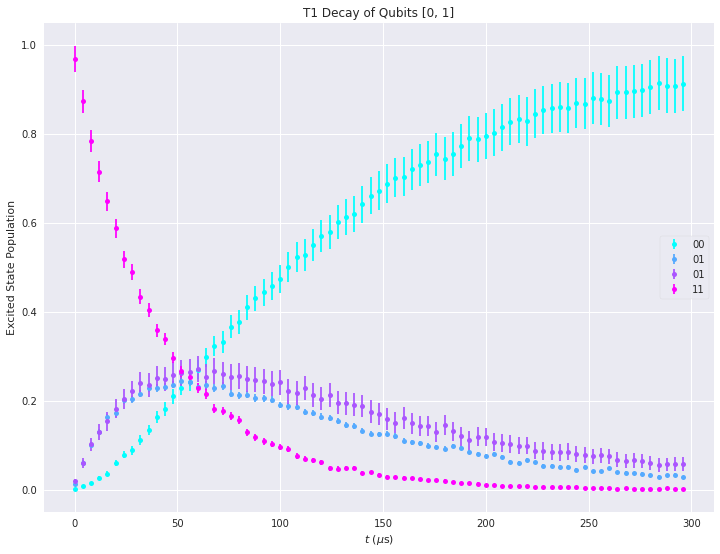

In [64]:
%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(figsize=(12, 9))

plt.title('T1 Decay of Qubits ' + str(qubits))
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('Excited State Population')
plt.ylim(-0.05, 1.05)

plt.errorbar(time, t1mit_lst00, t1ystd00, label = "00", marker='.', markersize=10, linestyle='', c = cool[0])
plt.errorbar(time, t1mit_lst01, t1ystd01, label = "01", marker='.', markersize=10, linestyle='', c = cool[1])
plt.errorbar(time, t1mit_lst10, t1ystd10, label = "01", marker='.', markersize=10, linestyle='', c = cool[2])
plt.errorbar(time, t1mit_lst11, t1ystd11, label = "11", marker='.', markersize=10, linestyle='', c = cool[3])

plt.legend(loc = "best", numpoints = 1, frameon = True)
    
plt.show()

## Plot the $T_2^*$ Results

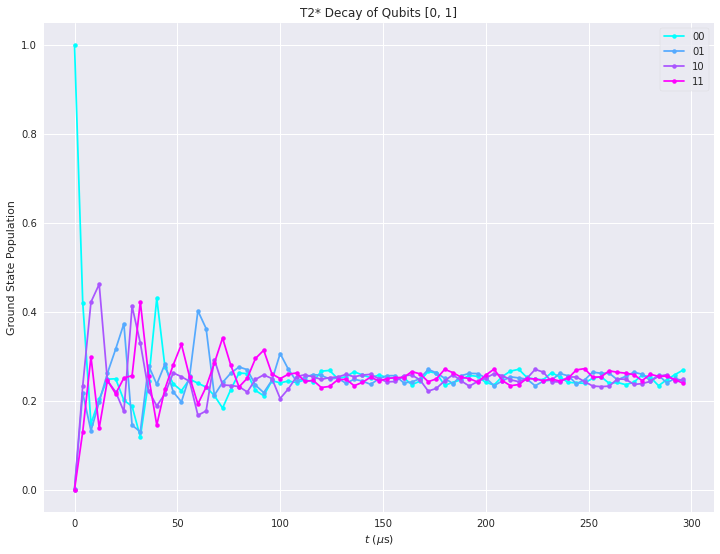

In [65]:
%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(figsize=(12, 9))

plt.title('T2* Decay of Qubits ' + str(qubits))
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('Ground State Population')
plt.ylim(-0.05, 1.05)

plt.plot(time, t2smit_lst00, label = "00", marker='.', markersize=9, c = cool[0])
plt.plot(time, t2smit_lst01, label = "01", marker='.', markersize=9, c = cool[1])
plt.plot(time, t2smit_lst10, label = "10", marker='.', markersize=9, c = cool[2])
plt.plot(time, t2smit_lst11, label = "11", marker='.', markersize=9, c = cool[3])

plt.legend(loc = "best", numpoints = 1, frameon = True)
    
plt.show()

## Plot the $T_2$ Echo Results

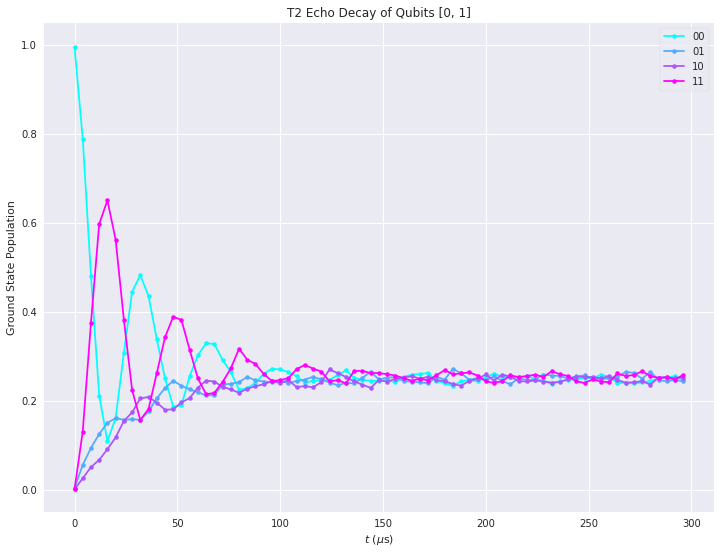

In [66]:
%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(figsize=(12, 9))

plt.title('T2 Echo Decay of Qubits ' + str(qubits))
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('Ground State Population')
plt.ylim(-0.05, 1.05)

plt.plot(time, t2emit_lst00, label = "00", marker='.', markersize=9, c = cool[0])
plt.plot(time, t2emit_lst01, label = "01", marker='.', markersize=9, c = cool[1])
plt.plot(time, t2emit_lst10, label = "10", marker='.', markersize=9, c = cool[2])
plt.plot(time, t2emit_lst11, label = "11", marker='.', markersize=9, c = cool[3])

plt.legend(loc = "best", numpoints = 1, frameon = True)
    
plt.show()

## Plot the $T_2$ CPMG Results



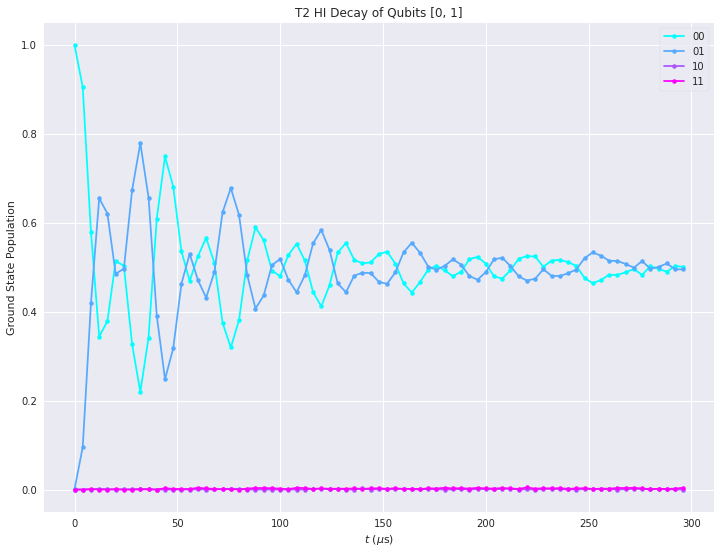

In [67]:
%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(figsize=(12, 9))

plt.title('T2 HI Decay of Qubits ' + str(qubits))
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('Ground State Population')
plt.ylim(-0.05, 1.05)

plt.plot(time, t2cmit_lst00, label = "00", marker='.', markersize=9, c = cool[0])
plt.plot(time, t2cmit_lst01, label = "01", marker='.', markersize=9, c = cool[1])
plt.plot(time, t2cmit_lst10, label = "10", marker='.', markersize=9, c = cool[2])
plt.plot(time, t2cmit_lst11, label = "11", marker='.', markersize=9, c = cool[3])

plt.legend(loc = "best", numpoints = 1, frameon = True)
    
plt.show()

## Plot the $T_2$ Hahn Results

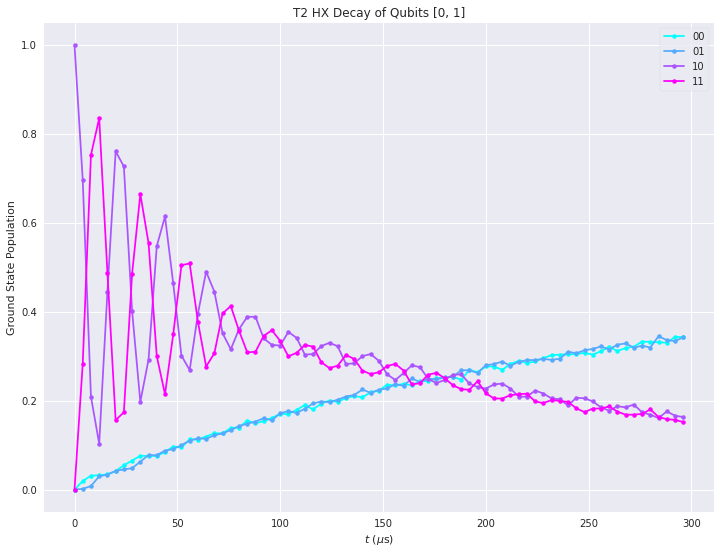

In [68]:
%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(figsize=(12, 9))

plt.title('T2 HX Decay of Qubits ' + str(qubits))
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('Ground State Population')
plt.ylim(-0.05, 1.05)

plt.plot(time, t2hmit_lst00, label = "00", marker='.', markersize=9, c = cool[0])
plt.plot(time, t2hmit_lst01, label = "01", marker='.', markersize=9, c = cool[1])
plt.plot(time, t2hmit_lst10, label = "10", marker='.', markersize=9, c = cool[2])
plt.plot(time, t2hmit_lst11, label = "11", marker='.', markersize=9, c = cool[3])

plt.legend(loc = "best", numpoints = 1, frameon = True)
    
plt.show()

# Numerical Solutions

In [69]:
sz = jnp.array([[1,0],[0,-1]], dtype = jnp.complex64)
sx = jnp.array([[0,1],[1,0]], dtype = jnp.complex64)
sy = jnp.array([[0, -1j],[1j, 0]], dtype = jnp.complex64)

zero = jnp.array([1, 0], dtype = jnp.complex64)
one = jnp.array([0, 1], dtype = jnp.complex64)
plus = 1/jnp.sqrt(2) * jnp.array([1, 1], dtype = jnp.complex64)
minus = 1/jnp.sqrt(2) * jnp.array([1, -1], dtype = jnp.complex64)
right = 1/jnp.sqrt(2) * (zero + 1j * one)
left = 1/jnp.sqrt(2) * (zero - 1j * one)

sp = jnp.outer(zero, one)
sm = jnp.outer(one, zero)

id2 = jnp.identity(2, dtype = jnp.complex64)
id3 = jnp.identity(3, dtype = jnp.complex64)
id4 = jnp.kron(id2, id2)

sz1 = jnp.kron(sz, id2)
sx1 = jnp.kron(sx, id2)
sy1 = jnp.kron(sy, id2)
sp1 = jnp.kron(sp, id2)
sm1 = jnp.kron(sm, id2)

sz2 = jnp.kron(id2, sz)
sx2 = jnp.kron(id2, sx)
sy2 = jnp.kron(id2, sy)
sp2 = jnp.kron(id2, sp)
sm2 = jnp.kron(id2, sm)

sv1 = jnp.array([sx1, sy1, sz1])
sv2 = jnp.array([sx2, sy2, sz2])

O1 = (jnp.identity(4) - sz1)/2
O2 = (jnp.identity(4) - sz2)/2

H2 = 1/jnp.sqrt(2) * jnp.array([[1, 1],
                                [1, -1]], dtype = jnp.complex64)

H4 = np.kron(H2, H2)

def ugate(t, p, l):
    u = jnp.array([[jnp.cos(t/2), - jnp.exp(1j * l) * jnp.sin(t/2)],
                  [jnp.exp(1j * p) * jnp.sin(t/2), jnp.exp(1j * (p + l)) * jnp.cos(t/2)]], dtype = jnp.complex64)
    return u

def u1gate(l):
    u = jnp.array([[1, 0],
                  [0, jnp.exp(1j * l)]], dtype = jnp.complex64)
    return u

def u2gate(p, l):
    u = 1/jnp.sqrt(2) * jnp.array([[1, -jnp.exp(1j * l)],
                                   [jnp.exp(1j * p), jnp.exp(1j * (p + l))]], dtype = jnp.complex64)
    return u

def dagger(A):
    return jnp.transpose(jnp.conjugate(A))

Y90 = jnp.kron(u2gate(0, 0), u2gate(0, 0))

X = jnp.kron(sx, sx)
Y = jnp.kron(sy, sy)

xdata = time / 1e6

In [70]:
def jdot(jmat, smat):
  jsum = []
  for i in range(len(smat)):
    rsum = []
    for j in range(len(smat)):
      rsum.append(jmat[i, j] * smat[j])
    jsum.append(sum(rsum))
  return jnp.array(jsum)

We will solve the following equation. The Quantum Master equation for a two-qubit system undergoing thermal relaxation and decoherence:
$$\frac{d \rho}{dt}=\mathcal{L}\rho,$$
where
$$\mathcal{L}\rho =-\imath[H,\rho]+\gamma_1(\langle n_1 \rangle +1)\left(\sigma_-^1\rho\sigma_+^1+\frac{1}{2}\left\{\sigma_+^1\sigma_-^1,\rho\right\}\right) + \gamma_1(\langle n_1 \rangle)\left(\sigma_+^1\rho\sigma_-^1+\frac{1}{2}\left\{\sigma_-^1\sigma_+^1,\rho\right\}\right) \\ + \gamma_2(\langle n_2 \rangle +1)\left(\sigma_-^2\rho\sigma_+^2+\frac{1}{2}\left\{\sigma_+^2\sigma_-^2,\rho\right\}\right) + \gamma_2(\langle n_2 \rangle)\left(\sigma_+^2\rho\sigma_-^2+\frac{1}{2}\left\{\sigma_-^2\sigma_+^2,\rho\right\}\right) \\ + \gamma_z^0 \left( \sigma_z^0 \rho \sigma_z^0 - \rho \right) + \gamma_z^1 \left( \sigma_z^1 \rho \sigma_z^1 - \rho \right)$$

and
$$
H = \frac{\omega_1}{2}\sigma_z^1 + \frac{\omega_2}{2}\sigma_z^2 + J\left(\sigma_+^1\sigma_-^2 + \sigma_-^1\sigma_+^2\right)
$$

$$
\gamma_1^1 = \gamma\left(\langle n_1 \rangle + 1\right)  \qquad\qquad \gamma_2^1 = \gamma\left(\langle n_1 \rangle\right)
$$

$$
\gamma_1^2 = \gamma\left(\langle n_2 \rangle + 1\right)  \qquad\qquad \gamma_2^2 = \gamma\left(\langle n_2 \rangle\right)
$$

$$
\langle n_x \rangle=\frac{1}{e^{\hbar\omega_x/kT}-1} \qquad\qquad x \in \{1, 2\}
$$

The initial condition of the $T_1$ solution is:
$$\rho(0)=|00\rangle\langle 00|,$$
where 
$$|0\rangle=\left(\begin{matrix}
1\\
0
\end{matrix}\right)$$

$$
\rho_0 = \begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
\end{pmatrix}
$$

The initial condition for the $T_2^*$ solution is:
$$\rho(0)=|++\rangle\langle ++|,$$
where 
$$|+\rangle=\frac{1}{\sqrt{2}}\left(\begin{matrix}
1\\
1
\end{matrix}\right)$$

$$
\rho_0 = \frac{1}{4} \begin{pmatrix}
1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 \\
\end{pmatrix}
$$

In [71]:
init = jnp.array(jnp.outer(jnp.kron(plus, plus), jnp.kron(plus, plus)), dtype = jnp.complex64)

inio = jnp.array(jnp.outer(jnp.kron(zero, zero), jnp.kron(zero, zero)), dtype = jnp.complex64)

ini1 = jnp.array(jnp.outer(jnp.kron(one, one), jnp.kron(one, one)), dtype = jnp.complex64)

inim = jnp.array(jnp.outer(jnp.kron(minus, minus), jnp.kron(minus, minus)), dtype = jnp.complex64)

inid = jnp.array(jnp.outer(jnp.kron(plus, minus), jnp.kron(plus, minus)), dtype = jnp.complex64)

inip = jnp.array(jnp.outer(jnp.kron(minus, plus), jnp.kron(minus, plus)), dtype = jnp.complex64)

iniP = jnp.array(jnp.outer(jnp.kron(plus, plus), jnp.kron(minus, minus)), dtype = jnp.complex64)

inir = jnp.array(jnp.outer(jnp.kron(right, right), jnp.kron(right, right)), dtype = jnp.complex64)

inil = jnp.array(jnp.outer(jnp.kron(left, left), jnp.kron(left, left)), dtype = jnp.complex64)

inix = jnp.diag(jnp.array([0.25, 0.25, 0.25, 0.25]))

In [72]:
xdata = time / 1e6
xd = time/1e3
qtime = jnp.linspace(0, 0.075, 75)
prmsl = [w0, w1, g1l[0], g1l[1], j01, n1, n2]
# prms1 = jnp.array([w0, w1, g1l[0] * 1e6, g1l[1] * 1e6, j01, n1, n2]) / 1e9
# prms2s = jnp.array([2 * w0, w1, 2 * g2l[0] * 1e6, 2 * g2l[1] * 1e6, j01 * 1e3, n1, n2]) / 1e9
# prms2e = jnp.array([w0, w1, g2l[0] * 1e6, g2l[1] * 1e6, j01, n1, n2]) / 1e9

# prms1 = jnp.array([g1l[0] * 1e6, g1l[1] * 1e6, j01, n1, n2]) / 1e9
# prms2s = jnp.array([6 * g2l[0] * 1e6, 6 * g2l[1] * 1e6, j01, n1, n2]) / 1e9
# prmsl_hc = jnp.array([g1l[0] * 1e6, g1l[1] * 1e6, j01 * 1e4, n1, n2]) / 1e9
# prms2e = jnp.array([g2l[0] * 1e6, g2l[1] * 1e6, j01, n1, n2]) / 1e9


prmsC = jnp.array([0, 0, w0, 0, 0, w1, j01/2, 0, 0, 0, j01/2, 0, 0, 0, 0,
                  g1l[0] * 1e6, g1l[1] * 1e6, 0, 0, n1, n2]) / 1e9
prmsHC = jnp.array([0, 0, w0, 0, 0, w1, j01/2 * 1e4, 0, 0, 0, j01/2 * 1e4, 0, 0,
                   0, 0, g2l[0] * 1e6, g2l[1] * 1e6, g2l[0] * 1e6, g2l[1] * 1e6, n1, n2]) / 1e9
prms2C = jnp.array([0, 0, w0, 0, 0, w1, j01/2, 0, 0, 0, j01/2, 0, 0, 0, 0,
                   g2l[0] * 1e6, g2l[1] * 1e6, g2l[0] * 1e6, g2l[1] * 1e6, n1, n2]) / 1e9
prms1 = jnp.array([w0, w0, w0, w1, w1, w1, j01/2, j01/2, j01/2, j01/2, j01/2, j01/2, j01/2,
                  j01/2, j01/2, g1l[0] * 1e6, g1l[1] * 1e6, g1l[0] * 1e6, g1l[1] * 1e6, n1, n2]) / 1e9
prms2s = jnp.array([w0, w0, w0, w1, w1, w1, j01/2 * 1e3, j01/2 * 1e3, j01/2 * 1e3, j01/2 * 1e3, j01/2 * 1e3, j01/2 *
                   1e3, j01/2 * 1e3, j01/2 * 1e3, j01/2 * 1e3, g2l[0] * 1e6, g2l[1] * 1e6, g2l[0] * 1e6, g2l[1] * 1e6, n1, n2]) / 1e9
prms2e = jnp.array([w0, w0, w0, w1, w1, w1, j01/2 * 1e3, j01/2 * 1e3, j01/2 * 1e3, j01/2 * 1e3, j01/2 * 1e3, j01/2 *
                   1e3, j01/2 * 1e3, j01/2 * 1e3, j01/2 * 1e3, g2l[0] * 1e6, g2l[1] * 1e6, g2l[0] * 1e6, g2l[1] * 1e6, n1, n2]) / 1e9
prmsl_hc = jnp.array([w0, w0, w0, w1, w1, w1, j01/2 * 1e4, j01/2 * 1e4, j01/2 * 1e4, j01/2 * 1e4, j01/2 * 1e4, j01 /
                     2 * 1e4, j01/2 * 1e4, j01/2 * 1e4, j01/2 * 1e4, g2l[0] * 1e6, g2l[1] * 1e6, 0, 0, n1, n2]) / 1e9


## Define the Master Equation Solvers

In [73]:
jdot(id3, sv2).shape

(3, 4, 4)

In [74]:
sv1.shape

(3, 4, 4)

In [75]:
sjs = 0
for i in range(3):
  sjs += jnp.dot(sv1[i], jdot(id3, sv2)[i])
sjs

DeviceArray([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
             [ 0.+0.j, -1.+0.j,  2.+0.j,  0.+0.j],
             [ 0.+0.j,  2.+0.j, -1.+0.j,  0.+0.j],
             [ 0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j]], dtype=complex64)

In [76]:
ve = jnp.array([1, 1, 1])
sum(jnp.dot(ve[i], sv1[i]))

DeviceArray([ 1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j], dtype=complex64)

In [77]:
vesum = []
for i in range(len(sv1)):
  vesum.append(ve[i] * sv1[i])
jnp.array(sum(vesum))

DeviceArray([[ 1.+0.j,  0.+0.j,  1.-1.j,  0.+0.j],
             [ 0.+0.j,  1.+0.j,  0.+0.j,  1.-1.j],
             [ 1.+1.j,  0.+0.j, -1.+0.j,  0.+0.j],
             [ 0.+0.j,  1.+1.j,  0.+0.j, -1.+0.j]], dtype=complex64)

In [78]:
jc = jnp.ones([3, 3])
jc = id3

jc = jnp.array([[1/2, 0, 0],
                [0, 1/2, 0],
                [0, 0, 0]])

sjs = 0
for i in range(3):
  sjs += jnp.dot(sv1[i], jdot(jc, sv2)[i])
sjs - (jnp.dot(sp1, sm2) + jnp.dot(sm1, sp2))

DeviceArray([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]], dtype=complex64)

In [79]:
# Function for the T1 Solution

@jit
def func_t1(r, wx0, wy0, wz0, wx1, wy1, wz1, jxx, jxy, jxz, jyx, jyy, jyz, jzx, jzy, jzz, cg1, cg2, cz1, cz2, pn1, pn2):

    W0 = jnp.array([wx0, wy0, wz0])
    W1 = jnp.array([wx1, wy1, wz1])
    jc = jnp.array([[jxx, jxy, jxz],
                    [jyx, jyy, jyz],
                    [jzx, jzy, jzz]])
    
    sjs = 0
    ws0 = []
    ws1 = []

    for i in range(3):
      sjs += jnp.dot(sv1[i], jdot(jc, sv2)[i])
    
    for i in range(3):
      ws0.append(W0[i] * sv1[i])
      ws1.append(W1[i] * sv2[i])
    ws0 = jnp.array(sum(ws0))
    ws1 = jnp.array(sum(ws1))

    def LinEm(x, t, omega0 = ws0, omega1 = ws1, gamma1 = cg1, gamma2 = cg2, gammaz1 = cz1, gammaz2 = cz2, J = sjs, N1 = pn1, N2 = pn2):
        x = x.reshape(4,4)
        H = omega0 + omega1 + J
        res = -1j*(jnp.dot(H, x) - jnp.dot(x, H))
        res += gamma1*(N1 + 1)*(multi_dot([sm1,x,sp1])-0.5*multi_dot([sp1,sm1,x])-0.5*multi_dot([x,sp1,sm1]))
        res += gamma1*(N1)*(multi_dot([sp1,x,sm1])-0.5*multi_dot([sm1,sp1,x])-0.5*multi_dot([x,sm1,sp1]))
        res += gamma2*(N2 + 1)*(multi_dot([sm2,x,sp2])-0.5*multi_dot([sp2,sm2,x])-0.5*multi_dot([x,sp2,sm2]))
        res += gamma2*(N2)*(multi_dot([sp2,x,sm2])-0.5*multi_dot([sm2,sp2,x])-0.5*multi_dot([x,sm2,sp2]))
        res += gammaz1 * (multi_dot([sz1, x, sz1]) - x)
        res += gammaz2 * (multi_dot([sz2, x, sz2]) - x)
        return res.ravel().astype(jnp.complex64)

    # sol = jnp.zeros((len(r),4,4),dtype=jnp.complex64)
    solint = jnp.array(odeint(LinEm,
                                    y0 = inio.ravel(),
                                    t = r).reshape(len(r), 4, 4), dtype=jnp.complex64)

    # for step in range(len(r)):
    #     sol = index_update(sol,
    #                        index[step],
    #                        solint[step])

    return solint

In [80]:
# Function for the T1 Solution

# jit
# def func_t1(r, cg1, cg2, jc, pn1, pn2):

#     W1 = w0 / 1e9
#     W2 = w1 / 1e9

#     def LinEm(x, t, omega1 = W1, omega2 = W2, gamma1 = cg1, gamma2 = cg2, J = jc, N1 = pn1, N2 = pn2):
#         x = x.reshape(4,4)
#         H = omega1/2 * sz1 + omega2/2 * sz2 + J*(jnp.kron(sp, sm) + jnp.kron(sm, sp))
#         res = -1j*(jnp.dot(H, x) - jnp.dot(x, H))
#         res += gamma1*(N1 + 1)*(multi_dot([sm1,x,sp1])-0.5*multi_dot([sp1,sm1,x])-0.5*multi_dot([x,sp1,sm1]))
#         res += gamma1*(N1)*(multi_dot([sp1,x,sm1])-0.5*multi_dot([sm1,sp1,x])-0.5*multi_dot([x,sm1,sp1]))
#         res += gamma2*(N2 + 1)*(multi_dot([sm2,x,sp2])-0.5*multi_dot([sp2,sm2,x])-0.5*multi_dot([x,sp2,sm2]))
#         res += gamma2*(N2)*(multi_dot([sp2,x,sm2])-0.5*multi_dot([sm2,sp2,x])-0.5*multi_dot([x,sm2,sp2]))   
#         return res.ravel().astype(jnp.complex64)

#     sol = jnp.zeros((len(r),4,4),dtype=jnp.complex64)
#     solint = jnp.array(odeint(LinEm,
#                                     y0 = inio.ravel(),
#                                     t = r).reshape(len(r), 4, 4), dtype=jnp.complex64)

#     for step in range(len(r)):
#         sol = index_update(sol,
#                            index[step],
#                            solint[step])

#     return sol

In [81]:
# Function for the T2* Solution

@jit
def func_t2s(r, wx0, wy0, wz0, wx1, wy1, wz1, jxx, jxy, jxz, jyx, jyy, jyz, jzx, jzy, jzz, cg1, cg2, cz1, cz2, pn1, pn2):

    W0 = jnp.array([wx0, wy0, wz0])
    W1 = jnp.array([wx1, wy1, wz1])
    jc = jnp.array([[jxx, jxy, jxz],
                    [jyx, jyy, jyz],
                    [jzx, jzy, jzz]])
    
    sjs = 0
    ws0 = []
    ws1 = []

    for i in range(3):
      sjs += jnp.dot(sv1[i], jdot(jc, sv2)[i])
    
    for i in range(3):
      ws0.append(W0[i] * sv1[i])
      ws1.append(W1[i] * sv2[i])
    ws0 = jnp.array(sum(ws0))
    ws1 = jnp.array(sum(ws1))

    def LinEm(x, t, omega0=ws0, omega1=ws1, gamma1=cg1, gamma2=cg2, gammaz1=cz1, gammaz2=cz2, J=sjs, N1=pn1, N2=pn2):
        x = x.reshape(4,4)
        H = omega0 + omega1 + J
        res = -1j*(jnp.dot(H, x) - jnp.dot(x, H))
        res += gamma1*(N1 + 1)*(multi_dot([sm1,x,sp1])-0.5*multi_dot([sp1,sm1,x])-0.5*multi_dot([x,sp1,sm1]))
        res += gamma1*(N1)*(multi_dot([sp1,x,sm1])-0.5*multi_dot([sm1,sp1,x])-0.5*multi_dot([x,sm1,sp1]))
        res += gamma2*(N2 + 1)*(multi_dot([sm2,x,sp2])-0.5*multi_dot([sp2,sm2,x])-0.5*multi_dot([x,sp2,sm2]))
        res += gamma2*(N2)*(multi_dot([sp2,x,sm2])-0.5*multi_dot([sm2,sp2,x])-0.5*multi_dot([x,sm2,sp2]))   
        res += gammaz1 * (multi_dot([sz1, x, sz1]) - x)
        res += gammaz2 * (multi_dot([sz2, x, sz2]) - x)
        return res.ravel().astype(jnp.complex64)

    sol = jnp.zeros((len(r),4,4),dtype=jnp.complex64)
    solint = jnp.array(odeint(LinEm,
                                    y0 = init.ravel(),
                                    t = r).reshape(len(r), 4, 4), dtype=jnp.complex64)

    for step in range(len(r)):
        # sol = index_update(sol,
        #                    index[step],
        #                    solint[step])
      sol = sol.at[step].set(solint[step])
    
    solH = jnp.zeros((len(r),4,4),dtype=jnp.complex64)
    
    X = jnp.kron(sx, sx)

    for step in range(len(r)):
        # solH = index_update(solH,
        #                     index[step],
        #                     multi_dot([X, H4, sol[step], H4, X]))
      solH = solH.at[step].set(multi_dot([X, H4, sol[step], H4, X]))

    return solH

In [82]:
# Function for the T2 Echo Solution

@jit
def func_t2e(r, wx0, wy0, wz0, wx1, wy1, wz1, jxx, jxy, jxz, jyx, jyy, jyz, jzx, jzy, jzz, cg1, cg2, cz1, cz2, pn1, pn2):

    W0 = jnp.array([wx0, wy0, wz0])
    W1 = jnp.array([wx1, wy1, wz1])
    jc = jnp.array([[jxx, jxy, jxz],
                    [jyx, jyy, jyz],
                    [jzx, jzy, jzz]])
    
    sjs = 0
    ws0 = []
    ws1 = []

    for i in range(3):
      sjs += jnp.dot(sv1[i], jdot(jc, sv2)[i])
    
    for i in range(3):
      ws0.append(W0[i] * sv1[i])
      ws1.append(W1[i] * sv2[i])
    ws0 = jnp.array(sum(ws0))
    ws1 = jnp.array(sum(ws1))

    def LinEm(x, t, omega0=ws0, omega1=ws1, gamma1=cg1, gamma2=cg2, gammaz1=cz1, gammaz2=cz2, J=sjs, N1=pn1, N2=pn2):
        x = x.reshape(4,4)
        H = omega0 + omega1 + J
        res = -1j*(jnp.dot(H, x) - jnp.dot(x, H))
        res += gamma1*(N1 + 1)*(multi_dot([sm1,x,sp1])-0.5*multi_dot([sp1,sm1,x])-0.5*multi_dot([x,sp1,sm1]))
        res += gamma1*(N1)*(multi_dot([sp1,x,sm1])-0.5*multi_dot([sm1,sp1,x])-0.5*multi_dot([x,sm1,sp1]))
        res += gamma2*(N2 + 1)*(multi_dot([sm2,x,sp2])-0.5*multi_dot([sp2,sm2,x])-0.5*multi_dot([x,sp2,sm2]))
        res += gamma2*(N2)*(multi_dot([sp2, x, sm2])-0.5 *
                            multi_dot([sm2, sp2, x])-0.5*multi_dot([x, sm2, sp2]))
        res += gammaz1 * (multi_dot([sz1, x, sz1]) - x)
        res += gammaz2 * (multi_dot([sz2, x, sz2]) - x)
        return res.ravel().astype(jnp.complex64)

    sol = jnp.zeros((len(r),4,4))
    
    solint1 = jnp.array(odeint(LinEm,
                               y0 = multi_dot([Y90, inio, dagger(Y90)]).ravel(),
                               t = r).reshape(len(r), 4, 4))
    
    solint2 = jnp.zeros((len(r),4,4))
    
    for stp in range(len(r)):
        # solint2 = index_update(solint2,
        #                        index[stp],
        #                        jnp.array(odeint(LinEm,
        #                                         y0 = multi_dot([Y, solint1[stp], Y]).ravel(),
        #                                         t=r)[stp].reshape(4, 4)))
        solint2 = solint2.at[stp].set(jnp.array(odeint(LinEm,
                                                y0=multi_dot(
                                                    [Y, solint1[stp], Y]).ravel(),
                                                t=r)[stp].reshape(4, 4)))

    for step in range(len(r)):
        # sol = index_update(sol,
        #                    index[step],
        #                    multi_dot([Y90, solint2[step], dagger(Y90)]))
        sol = sol.at[step].set(
            multi_dot([Y90, solint2[step], dagger(Y90)]))

    return sol

In [83]:
# Function for the Half T2* Solution

@jit
def func_t2sh(r, wx0, wy0, wz0, wx1, wy1, wz1, jxx, jxy, jxz, jyx, jyy, jyz, jzx, jzy, jzz, cg1, cg2, cz1, cz2, pn1, pn2):

    W0 = jnp.array([wx0, wy0, wz0])
    W1 = jnp.array([wx1, wy1, wz1])
    jc = jnp.array([[jxx, jxy, jxz],
                    [jyx, jyy, jyz],
                    [jzx, jzy, jzz]])
    
    sjs = 0
    ws0 = []
    ws1 = []

    for i in range(3):
      sjs += jnp.dot(sv1[i], jdot(jc, sv2)[i])
    
    for i in range(3):
      ws0.append(W0[i] * sv1[i])
      ws1.append(W1[i] * sv2[i])
    ws0 = jnp.array(sum(ws0))
    ws1 = jnp.array(sum(ws1))

    def LinEm(x, t, omega0=ws0, omega1=ws1, gamma1=cg1, gamma2=cg2, gammaz1=cz1, gammaz2=cz2, J=sjs, N1=pn1, N2=pn2):
        x = x.reshape(4,4)
        H = omega0 + omega1 + J
        res = -1j*(jnp.dot(H, x) - jnp.dot(x, H))
        res += gamma1*(N1 + 1)*(multi_dot([sm1,x,sp1])-0.5*multi_dot([sp1,sm1,x])-0.5*multi_dot([x,sp1,sm1]))
        res += gamma1*(N1)*(multi_dot([sp1,x,sm1])-0.5*multi_dot([sm1,sp1,x])-0.5*multi_dot([x,sm1,sp1]))
        res += gamma2*(N2 + 1)*(multi_dot([sm2,x,sp2])-0.5*multi_dot([sp2,sm2,x])-0.5*multi_dot([x,sp2,sm2]))
        res += gamma2*(N2)*(multi_dot([sp2, x, sm2])-0.5 *
                            multi_dot([sm2, sp2, x])-0.5*multi_dot([x, sm2, sp2]))
        res += gammaz1 * (multi_dot([sz1, x, sz1]) - x)
        res += gammaz2 * (multi_dot([sz2, x, sz2]) - x)
        return res.ravel().astype(jnp.complex64)

    Hh = jnp.kron(H2, id2)

    sol = jnp.zeros((len(r),4,4),dtype=jnp.complex64)
    solint = jnp.array(odeint(LinEm,
                                    y0 = multi_dot([Hh, inio, dagger(Hh)]).ravel(),
                                    t = r).reshape(len(r), 4, 4), dtype=jnp.complex64)

    for step in range(len(r)):
        # sol = index_update(sol,
        #                    index[step],
        #                    solint[step])
        sol = sol.at[step].set(solint[step])
    
    solH = jnp.zeros((len(r),4,4),dtype=jnp.complex64)
    
    X = jnp.kron(sx, sx)

    for step in range(len(r)):
        # solH = index_update(solH,
        #                     index[step],
        #                     multi_dot([Hh, sol[step], dagger(Hh)]))
        solH = solH.at[step].set(multi_dot([Hh, sol[step], dagger(Hh)]))

    return solH

In [84]:
# Function for the HI T2* Solution

@jit
def func_t2hi(r, wx0, wy0, wz0, wx1, wy1, wz1, jxx, jxy, jxz, jyx, jyy, jyz, jzx, jzy, jzz, cg1, cg2, cz1, cz2, pn1, pn2):

    W0 = jnp.array([wx0, wy0, wz0])
    W1 = jnp.array([wx1, wy1, wz1])
    jc = jnp.array([[jxx, jxy, jxz],
                    [jyx, jyy, jyz],
                    [jzx, jzy, jzz]])
    
    sjs = 0
    ws0 = []
    ws1 = []

    for i in range(3):
      sjs += jnp.dot(sv1[i], jdot(jc, sv2)[i])
    
    for i in range(3):
      ws0.append(W0[i] * sv1[i])
      ws1.append(W1[i] * sv2[i])
    ws0 = jnp.array(sum(ws0))
    ws1 = jnp.array(sum(ws1))

    def LinEm(x, t, omega0=ws0, omega1=ws1, gamma1=cg1, gamma2=cg2, gammaz1=cz1, gammaz2=cz2, J=sjs, N1=pn1, N2=pn2):
        x = x.reshape(4,4)
        H = omega0 + omega1 + J
        res = -1j*(jnp.dot(H, x) - jnp.dot(x, H))
        res += gamma1*(N1 + 1)*(multi_dot([sm1,x,sp1])-0.5*multi_dot([sp1,sm1,x])-0.5*multi_dot([x,sp1,sm1]))
        res += gamma1*(N1)*(multi_dot([sp1,x,sm1])-0.5*multi_dot([sm1,sp1,x])-0.5*multi_dot([x,sm1,sp1]))
        res += gamma2*(N2 + 1)*(multi_dot([sm2,x,sp2])-0.5*multi_dot([sp2,sm2,x])-0.5*multi_dot([x,sp2,sm2]))
        res += gamma2*(N2)*(multi_dot([sp2, x, sm2])-0.5 *
                            multi_dot([sm2, sp2, x])-0.5*multi_dot([x, sm2, sp2]))
        res += gammaz1 * (multi_dot([sz1, x, sz1]) - x)
        res += gammaz2 * (multi_dot([sz2, x, sz2]) - x)
        return res.ravel().astype(jnp.complex64)

    Hh = jnp.kron(H2, id2)
    Hx = jnp.kron(H2, sx)

    sol = jnp.zeros((len(r),4,4),dtype=jnp.complex64)
    solint = jnp.array(odeint(LinEm,
                                    y0 = multi_dot([Hx, inio, Hx]).ravel(),
                                    t = r).reshape(len(r), 4, 4), dtype=jnp.complex64)

    for step in range(len(r)):
        # sol = index_update(sol,
        #                    index[step],
        #                    solint[step])
        sol = sol.at[step].set(solint[step])
    
    solH = jnp.zeros((len(r),4,4),dtype=jnp.complex64)
    
    X = jnp.kron(sx, sx)

    for step in range(len(r)):
        # solH = index_update(solH,
        #                     index[step],
        #                     multi_dot([Hh, sol[step], Hh]))
        solH = solH.at[step].set(multi_dot([Hh, sol[step], Hh]))

    return solH

## Plot the solutions

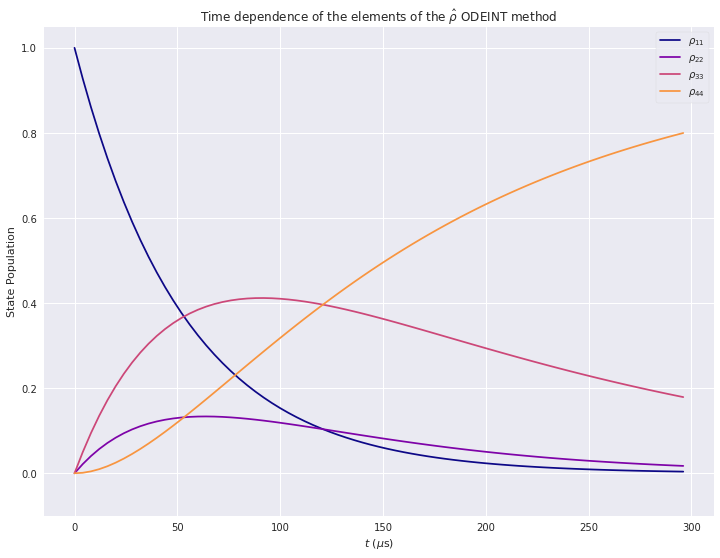

In [85]:
# T1 Solution

%matplotlib inline
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(12, 9))

T1Sols = func_t1(xd, *prmsC)

plt.plot(time, T1Sols[:, 0, 0], label = r'$\rho_{11}$', color = plasma[0])
plt.plot(time, T1Sols[:, 1, 1], label = r'$\rho_{22}$', color = plasma[1])
plt.plot(time, T1Sols[:, 2, 2], label = r'$\rho_{33}$', color = plasma[2])
plt.plot(time, T1Sols[:, 3, 3], label = r'$\rho_{44}$', color = plasma[3])

plt.title('Time dependence of the elements of the '+r'$\hat{\rho}$'+' ODEINT method')
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('State Population')
plt.ylim(-0.1, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

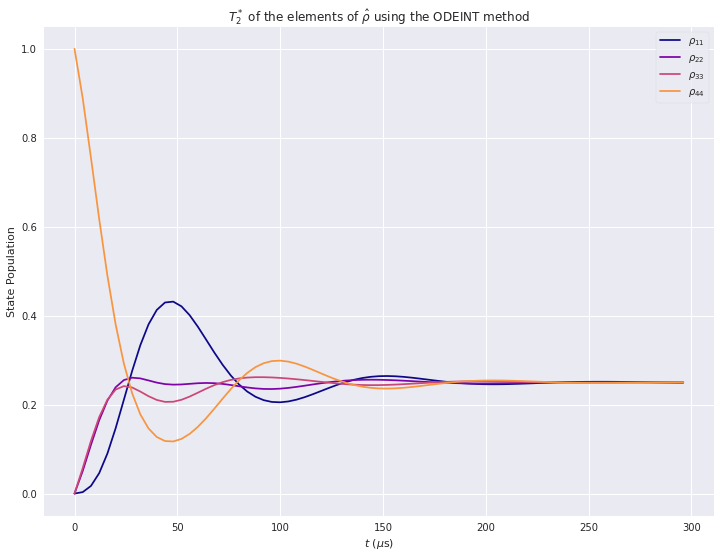

In [86]:
# T2 Star Solution

%matplotlib inline
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(12, 9))

# prms2s = jnp.array([5 * w0, w1, 2 * g2l[0] * 1e6, 2 * g2l[1] * 1e6, j01 * 1e3, n1, n2]) / 1e9

T2sSols = func_t2s(xd, *prms2C)

plt.plot(time, T2sSols[:, 0, 0], label = r'$\rho_{11}$', color = plasma[0])
plt.plot(time, T2sSols[:, 1, 1], label = r'$\rho_{22}$', color = plasma[1])
plt.plot(time, T2sSols[:, 2, 2], label = r'$\rho_{33}$', color = plasma[2])
plt.plot(time, T2sSols[:, 3, 3], label = r'$\rho_{44}$', color = plasma[3])

plt.title(r'$T_2^*$' + ' of the elements of '+r'$\hat{\rho}$'+' using the ODEINT method')
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('State Population')
# plt.ylim(-0.1, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

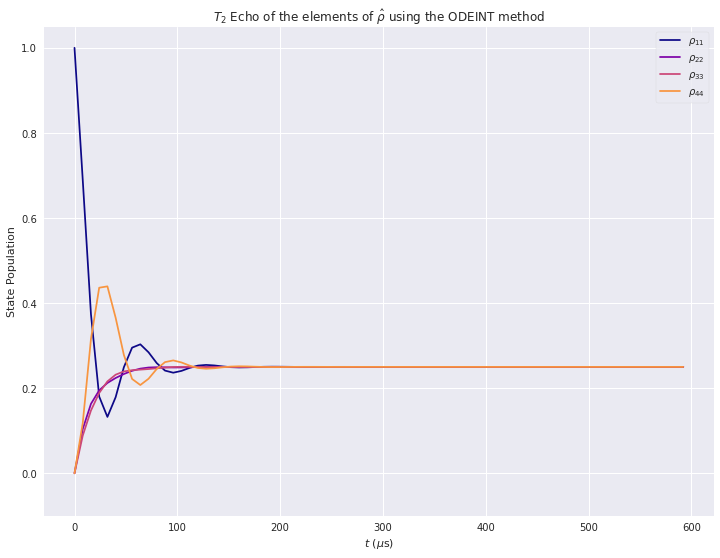

In [87]:
# T2 Echo Solution

%matplotlib inline
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(12, 9))

# prmsl_hc = jnp.array([g1l[0] * 1e6, g1l[1] * 1e6, j01 * 1e4, n1, n2]) / 1e9

T2eSols = func_t2e(xd * 1.3, *prmsHC)

plt.plot(time * 2, T2eSols[:, 0, 0], label = r'$\rho_{11}$', color = plasma[0])
plt.plot(time * 2, T2eSols[:, 1, 1], label = r'$\rho_{22}$', color = plasma[1])
plt.plot(time * 2, T2eSols[:, 2, 2], label = r'$\rho_{33}$', color = plasma[2])
plt.plot(time * 2, T2eSols[:, 3, 3], label = r'$\rho_{44}$', color = plasma[3])

plt.title(r'$T_2$' + ' Echo of the elements of '+r'$\hat{\rho}$'+' using the ODEINT method')
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('State Population')
plt.ylim(-0.1, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

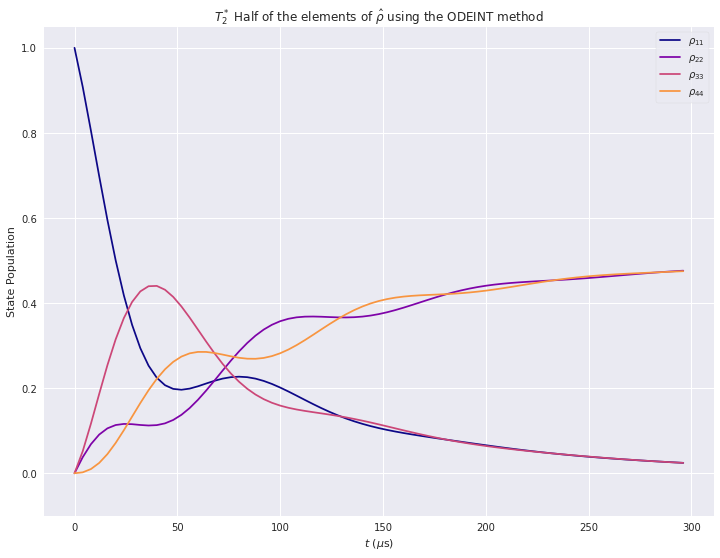

In [88]:
# Half T2* Solution

%matplotlib inline
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(12, 9))

# prmsl_hc = jnp.array([g1l[0] * 1e6, g1l[1] * 1e6, j01 * 1e4, n1, n2]) / 1e9

T2shSols = func_t2sh(xd, *prms2C)

plt.plot(time, T2shSols[:, 0, 0], label = r'$\rho_{11}$', color = plasma[0])
plt.plot(time, T2shSols[:, 1, 1], label = r'$\rho_{22}$', color = plasma[1])
plt.plot(time, T2shSols[:, 2, 2], label = r'$\rho_{33}$', color = plasma[2])
plt.plot(time, T2shSols[:, 3, 3], label = r'$\rho_{44}$', color = plasma[3])

plt.title(r'$T_2^*$' + ' Half of the elements of '+r'$\hat{\rho}$'+' using the ODEINT method')
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('State Population')
plt.ylim(-0.1, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

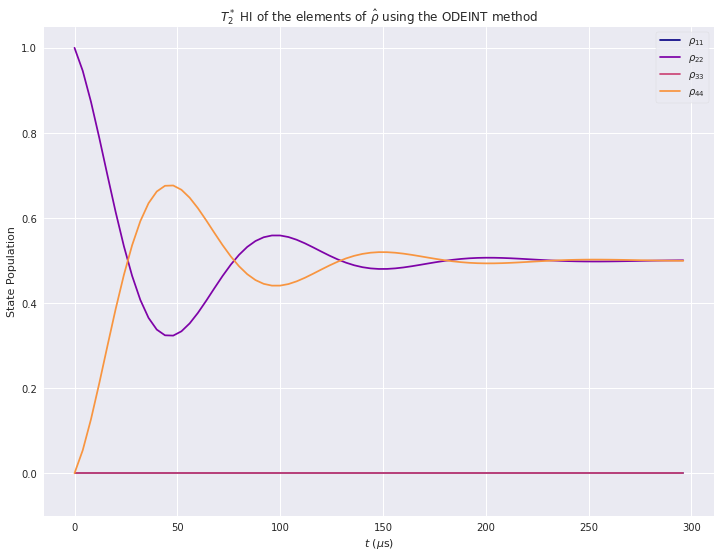

In [89]:
# HI T2* Solution

%matplotlib inline
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(12, 9))

# prmsl_hc = jnp.array([g1l[0] * 1e6, g1l[1] * 1e6, j01 * 1e4, n1, n2]) / 1e9

T2hiSols = func_t2hi(xd, *prms2C)

plt.plot(time, T2hiSols[:, 0, 0], label = r'$\rho_{11}$', color = plasma[0])
plt.plot(time, T2hiSols[:, 1, 1], label = r'$\rho_{22}$', color = plasma[1])
plt.plot(time, T2hiSols[:, 2, 2], label = r'$\rho_{33}$', color = plasma[2])
plt.plot(time, T2hiSols[:, 3, 3], label = r'$\rho_{44}$', color = plasma[3])

plt.title(r'$T_2^*$' + ' HI of the elements of '+r'$\hat{\rho}$'+' using the ODEINT method')
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('State Population')
plt.ylim(-0.1, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

## Compare the device parameters to the experimental results

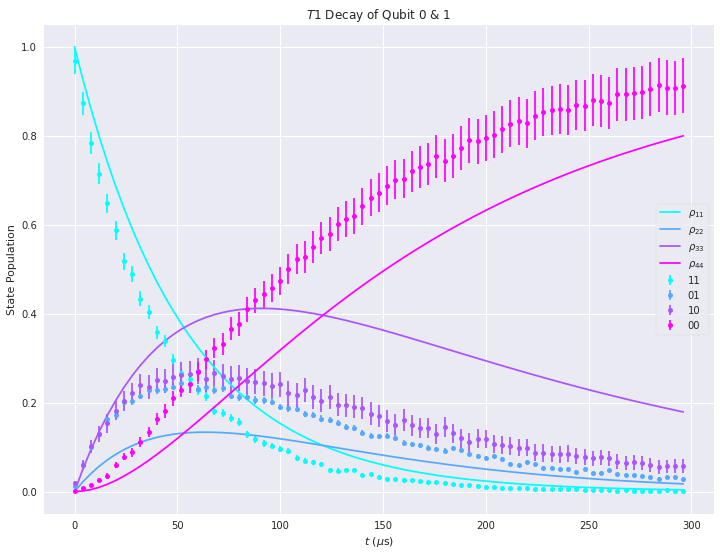

In [90]:
# T1 Solution and Experiments

%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(figsize=(12, 9))

plt.errorbar(time, t1mit_lst11, t1ystd11, label = "11", marker='.', markersize=10, linestyle='', c = cool[0])
plt.errorbar(time, t1mit_lst01, t1ystd01, label = "01", marker='.', markersize=10, linestyle='', c = cool[1])
plt.errorbar(time, t1mit_lst10, t1ystd10, label = "10", marker='.', markersize=10, linestyle='', c = cool[2])
plt.errorbar(time, t1mit_lst00, t1ystd00, label = "00", marker='.', markersize=10, linestyle='', c = cool[3])

plt.plot(time, T1Sols[:, 0, 0], label = r'$\rho_{11}$', color = cool[0])
plt.plot(time, T1Sols[:, 1, 1], label = r'$\rho_{22}$', color = cool[1])
plt.plot(time, T1Sols[:, 2, 2], label = r'$\rho_{33}$', color = cool[2])
plt.plot(time, T1Sols[:, 3, 3], label = r'$\rho_{44}$', color = cool[3])

plt.title('$T1$ Decay of Qubit 0 & 1')
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('State Population')
plt.ylim(-0.05, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

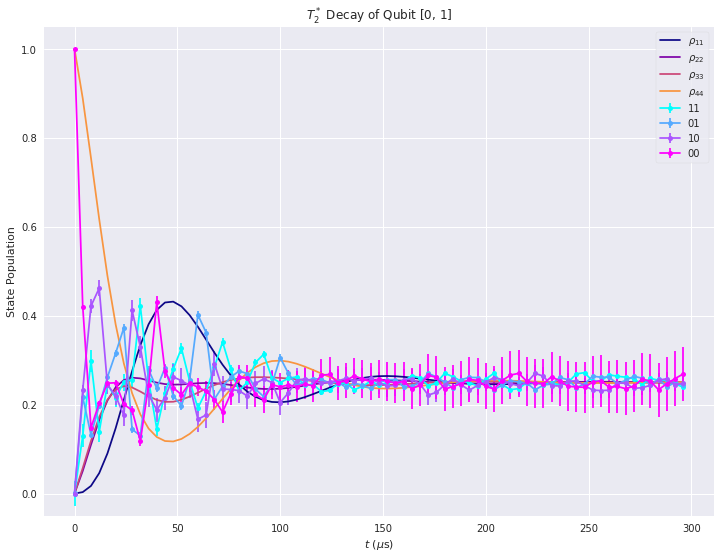

In [91]:
# T2 Star Solution and Experiments

%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(figsize=(12, 9))

plt.errorbar(time, t2smit_lst11, t1ystd11, label = "11", marker='.', markersize=10, c = cool[0])
plt.errorbar(time, t2smit_lst01, t1ystd01, label = "01", marker='.', markersize=10, c = cool[1])
plt.errorbar(time, t2smit_lst10, t1ystd10, label = "10", marker='.', markersize=10, c = cool[2])
plt.errorbar(time, t2smit_lst00, t1ystd00, label = "00", marker='.', markersize=10, c = cool[3])

plt.plot(time, T2sSols[:, 0, 0], label = r'$\rho_{11}$', color = plasma[0])
plt.plot(time, T2sSols[:, 1, 1], label = r'$\rho_{22}$', color = plasma[1])
plt.plot(time, T2sSols[:, 2, 2], label = r'$\rho_{33}$', color = plasma[2])
plt.plot(time, T2sSols[:, 3, 3], label = r'$\rho_{44}$', color = plasma[3])

plt.title('$T_2^*$ Decay of Qubit ' + str(qubits))
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('State Population')
plt.ylim(-0.05, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

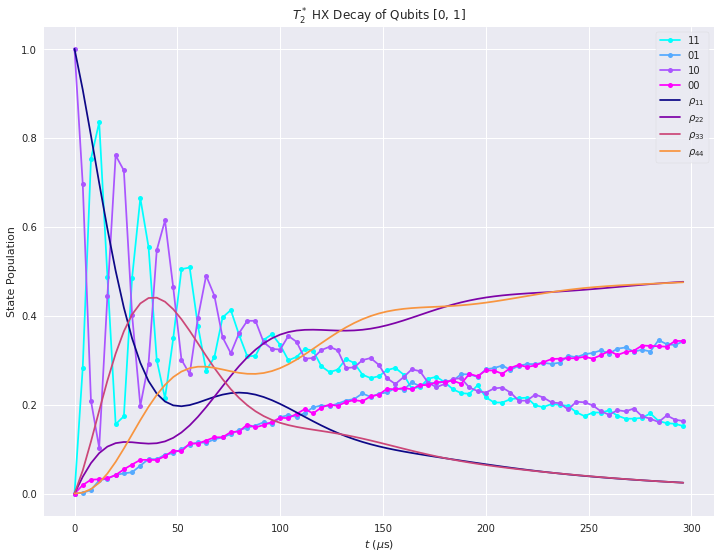

In [92]:
# T2* HX Solution and Experiments

%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(figsize=(12, 9))

plt.plot(time, t2hmit_lst11, label = "11", marker='.', markersize=10, c = cool[0])
plt.plot(time, t2hmit_lst01, label = "01", marker='.', markersize=10, c = cool[1])
plt.plot(time, t2hmit_lst10, label = "10", marker='.', markersize=10, c = cool[2])
plt.plot(time, t2hmit_lst00, label = "00", marker='.', markersize=10, c = cool[3])

plt.plot(time, T2shSols[:, 0, 0], label = r'$\rho_{11}$', color = plasma[0])
plt.plot(time, T2shSols[:, 1, 1], label = r'$\rho_{22}$', color = plasma[1])
plt.plot(time, T2shSols[:, 2, 2], label = r'$\rho_{33}$', color = plasma[2])
plt.plot(time, T2shSols[:, 3, 3], label = r'$\rho_{44}$', color = plasma[3])

plt.title('$T_2^*$ HX Decay of Qubits ' + str(qubits))
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('State Population')
plt.ylim(-0.05, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

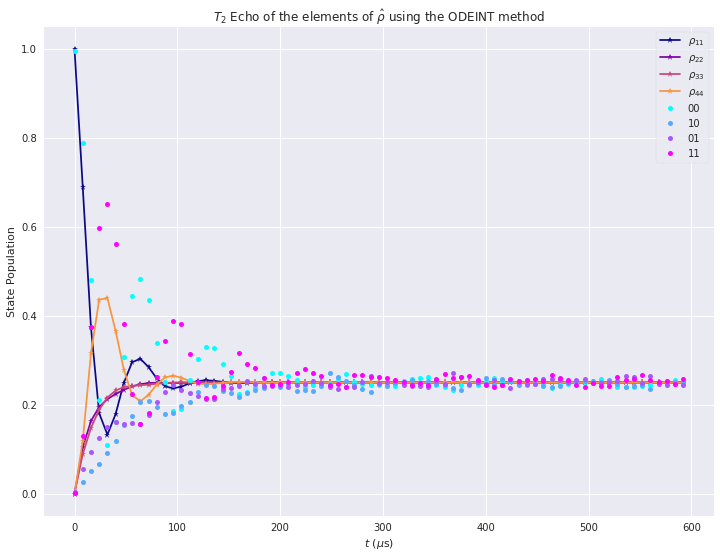

In [93]:
# T2 Echo Solution and Experiments

%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(figsize=(12, 9))

plt.plot(time * 2, T2eSols[:, 0, 0], label = r'$\rho_{11}$', marker='*', color = plasma[0])
plt.plot(time * 2, T2eSols[:, 1, 1], label = r'$\rho_{22}$', marker='*', color = plasma[1])
plt.plot(time * 2, T2eSols[:, 2, 2], label = r'$\rho_{33}$', marker='*', color = plasma[2])
plt.plot(time * 2, T2eSols[:, 3, 3], label = r'$\rho_{44}$', marker='*', color = plasma[3])

plt.plot(time * 2, t2emit_lst00, label = "00", marker='.', linestyle = '', markersize=10, c = cool[0])
plt.plot(time * 2, t2emit_lst10, label = "10", marker='.', linestyle = '', markersize=10, c = cool[1])
plt.plot(time * 2, t2emit_lst01, label = "01", marker='.', linestyle = '', markersize=10, c = cool[2])
plt.plot(time * 2, t2emit_lst11, label = "11", marker='.', linestyle = '', markersize=10, c = cool[3])

plt.title(r'$T_2$' + ' Echo of the elements of '+r'$\hat{\rho}$'+' using the ODEINT method')
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('State Population')
# plt.ylim(-0.1, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

In [94]:
((xd)[:5] * unts.ms).to(unts.us) * 0.3

<Quantity [0. , 1.2, 2.4, 3.6, 4.8] us>

In [95]:
((xd)[-5:] * unts.ms).to(unts.us) * 0.3

<Quantity [84. , 85.2, 86.4, 87.6, 88.8] us>

## Data Optimisation

In [96]:
# Least Squares Function

def mse(observations, estimates):
    '''
    INPUT:
        observations - numpy array of values indicating observed values
        estimates - numpy array of values indicating an estimate of values
    OUTPUT:
        Mean Square Error value
    '''
    
    obav = []
    diff = []
    var = []
    dlen = len(time)
    
    for i in range(N):
        obav.append(sum(observations[i])/dlen)
    
    for d in range(N):
        diff.append(jnp.abs(observations[d] - estimates[d]))
    
    for a in range(N):
        var.append(jnp.abs(observations[a] - obav[a]))
    
    sq_diff = sum(diff) ** 2
    mse = sum(sq_diff)
    vari = sum(sum(var) ** 2)
    r2 = (1 - (mse/vari)) * 100
    
    return mse

In [97]:
def reg(observations, estimates):
    obav = []
    diff = []
    var = []
    dlen = len(time)
    
    for i in range(N):
        obav.append(sum(observations[i])/dlen)
    
    for d in range(N):
        diff.append(jnp.abs(observations[d] - estimates[d]))
    
    for a in range(N):
        var.append(jnp.abs(observations[a] - obav[a]))
    
    sq_diff = sum(diff) ** 2
    mse = sum(sq_diff)
    vari = sum(sum(var) ** 2)
    r2 = (1 - (mse/vari)) * 100
    
    return r2

In [98]:
# Minimise the LstSqrs Function

def minmse(y):
    Y = y[0]
    
    rhot1 = func_t1(xd, *Y)
    
    t1data = jnp.array(t1mit_lst11, dtype=jnp.float64)
    t2data = jnp.array(t1mit_lst01, dtype=jnp.float64)
    t3data = jnp.array(t1mit_lst10, dtype=jnp.float64)
    t4data = jnp.array(t1mit_lst00, dtype=jnp.float64)
    tdata = [t1data, t2data, t3data, t4data]
    
    tst1 = rhot1[:, 0, 0]
    tst2 = rhot1[:, 1, 1]
    tst3 = rhot1[:, 2, 2]
    tst4 = rhot1[:, 3, 3]
    tstd = [tst1, tst2, tst3, tst4]
    
    return mse(tdata, tstd)

In [99]:
minmse(jnp.array([prmsC]))

DeviceArray(10.977644, dtype=float32)

In [100]:
# Define an adam gradient descent optimiser

minfunc = vmap(minmse)

scorelst = []
tlst = []

# bounds = jnp.array([w0, w1, g1l[0], g1l[1], j01, n1, n2], dtype = jnp.float32)

def adam_jack(bound, n_iter, alpha, beta1, beta2, eps=1e-8):
  x = bound
  first = x
  best = x
  worst = x
  score = minfunc(jnp.array([[x]]))
  # score = minmse(jnp.array([x]))
  scbest = score
  print('f(%s) = %f' % (x, score))
  
  J = jacrev(minmse)
  
  m = jnp.zeros(len(prms1))
  v = jnp.zeros(len(prms1))
  
  for t in range(n_iter + 1):
      # calculate gradient g(t)
      g = J([x])[0]
      
      m = beta1 * m + (1.0 - beta1) * g
      v = beta2 * v + (1.0 - beta2) * g**2
      
      mhat = m / (1.0 - beta1**(t+1))
      vhat = v / (1.0 - beta2**(t+1))
      
      x = x - alpha * mhat / (sqrt(vhat) + eps)
      
      for i in range(len(x)):
          if x[i] < 0:
            #   x = index_update(x, index[i], bound[i])
              x = x.at[i].set(bound[i])
      
      if scbest > minmse(jnp.array([x])):
          best = x
          scbest = minmse(jnp.array([best]))
      
      # evaluate candidate point
      score = minfunc(jnp.array([[x]]))
      # score = minmse(jnp.array([x]))
      scorelst.append(score)
      tlst.append(t)
      print('>%d => %f' % (t, score))
  return [best, scbest]

In [101]:
# bnds = prms1
bnds = prmsC
# bnds = best
# bnds = prmsl_hc

In [102]:
# Run the gradient descent algorithm

# define the total iterations
n_iter = 1000
# steps size
alpha = 0.1
# factor for average gradient
beta1 = 0.8
# factor for average squared gradient
beta2 = 0.999
# perform the gradient descent search with adam
best, score = adam_jack(bnds, n_iter, alpha, beta1, beta2)
print('Done!')
print('f(%s) = %f' % (best, score))

f([0.0000000e+00 0.0000000e+00 3.0368279e+01 0.0000000e+00 0.0000000e+00
 2.9053747e+01 3.6890528e-03 0.0000000e+00 0.0000000e+00 0.0000000e+00
 3.6890528e-03 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 1.3027291e+01 5.7388792e+00 0.0000000e+00 0.0000000e+00 1.9234069e-16
 3.7564614e-16]) = 10.977644
>0 => 10.600546
>1 => 8.667219
>2 => 8.083771
>3 => 7.715878
>4 => 7.448661
>5 => 7.205320
>6 => 6.939943
>7 => 6.630606
>8 => 6.271689
>9 => 5.868368
>10 => 5.433592
>11 => 4.987131
>12 => 4.554692
>13 => 4.158010
>14 => 3.820187
>15 => 3.530601
>16 => 3.270764
>17 => 3.018438
>18 => 2.761504
>19 => 2.507566
>20 => 2.271666
>21 => 2.064527
>22 => 1.887408
>23 => 1.732736
>24 => 1.595643
>25 => 1.468070
>26 => 1.351208
>27 => 1.249384
>28 => 1.162265
>29 => 1.088595
>30 => 1.025447
>31 => 0.966801
>32 => 0.913280
>33 => 0.867246
>34 => 0.829301
>35 => 0.793869
>36 => 0.760625
>37 => 0.730772
>38 => 0.703640
>39 => 0.679018
>40 => 0.655311
>41 => 0.633966
>42 => 0.614534
>43 =>

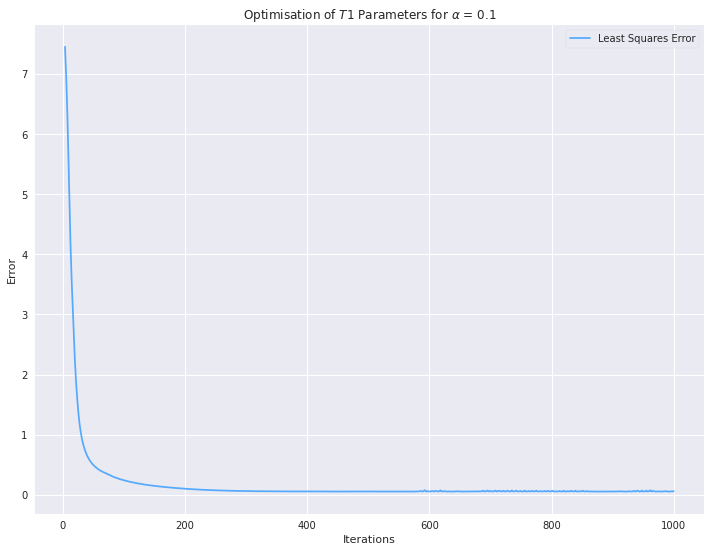

In [103]:
%matplotlib inline
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(12, 9))

plt.plot(tlst[4:], scorelst[4:], label = 'Least Squares Error', color = cool[1])

plt.title('Optimisation of $T1$ Parameters for ' + r'$\alpha$' + ' = ' + str(alpha))
plt.xlabel('Iterations')
plt.ylabel('Error')
# plt.ylim(-0.05, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

## Plot the fitted results

In [104]:
t1_best = func_t1(xd, *best)

In [105]:
#R2 Regression

np.round(reg([jnp.array(t1mit_lst11, dtype=jnp.float64), jnp.array(t1mit_lst01, dtype=jnp.float64), jnp.array(t1mit_lst10, dtype=jnp.float64), jnp.array(t1mit_lst00, dtype=jnp.float64)],
    [t1_best[:, 0, 0], t1_best[:, 1, 1], t1_best[:, 2, 2], t1_best[:, 3, 3]]), 2)

DeviceArray(99.81, dtype=float32)

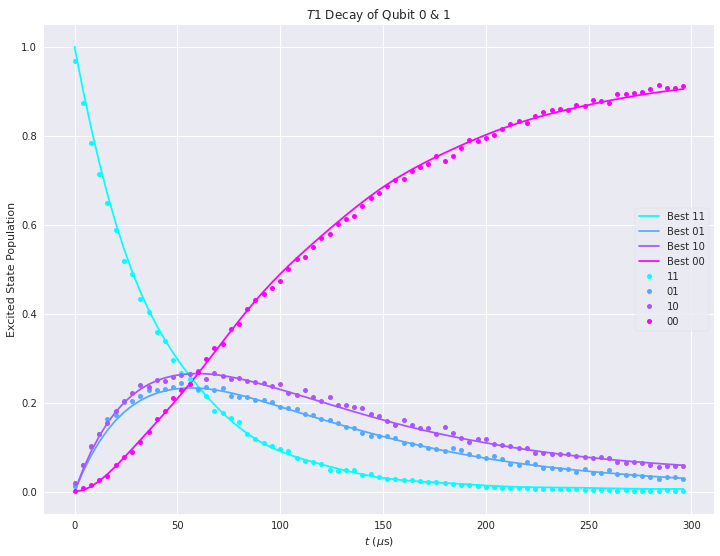

In [106]:
%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(figsize=(12, 9))

plt.plot(time, t1_best[:, 0, 0], label = 'Best 11', color = cool[0])
plt.plot(time, t1_best[:, 1, 1], label = 'Best 01', color = cool[1])
plt.plot(time, t1_best[:, 2, 2], label = 'Best 10', color = cool[2])
plt.plot(time, t1_best[:, 3, 3], label = 'Best 00', color = cool[3])
plt.plot(time, t1mit_lst11, label = '11', marker='.', markersize=10, linestyle='', color = cool[0])
plt.plot(time, t1mit_lst01, label = '01', marker='.', markersize=10, linestyle='', color = cool[1])
plt.plot(time, t1mit_lst10, label = '10', marker='.', markersize=10, linestyle='', color = cool[2])
plt.plot(time, t1mit_lst00, label = '00', marker='.', markersize=10, linestyle='', color = cool[3])

plt.title('$T1$ Decay of Qubit 0 & 1')
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('Excited State Population')
plt.ylim(-0.05, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

## Same now for $T_2^*$

In [107]:
def minmse2(y):
    Y = y[0]
    
    rhot2s = func_t2sh(xd, *Y)
    
    t1data = jnp.array(t2hmit_lst10, dtype=jnp.float64)
    t2data = jnp.array(t2hmit_lst00, dtype=jnp.float64)
    t3data = jnp.array(t2hmit_lst11, dtype=jnp.float64)
    t4data = jnp.array(t2hmit_lst01, dtype=jnp.float64)
    tdata = [t1data, t2data, t3data, t4data]
    
    tst1 = rhot2s[:, 0, 0]
    tst2 = rhot2s[:, 1, 1]
    tst3 = rhot2s[:, 2, 2]
    tst4 = rhot2s[:, 3, 3]
    tstd = [tst1, tst2, tst3, tst4]
    
    return mse(tdata, tstd)

In [108]:
minmse2([prms2s])

DeviceArray(17.53777, dtype=float32)

In [109]:
# Define an adam gradient descent optimiser

minfunc = vmap(minmse2)

scorelst = []
tlst = []

# bounds = jnp.array([w0, w1, g2l[0], g2l[1], j01, n1, n2], dtype = jnp.float32)

def adam_jack2(bounds, n_iter, alpha, beta1, beta2, eps=1e-8):
    x = bounds
    first = x
    best = x
    worst = x
    score = minfunc(jnp.array([[x]]))
    scbest = score
    print('f(%s) = %f' % (x, score))
    
    J = jacrev(minmse2)
    
    m = jnp.zeros(len(prms2s))
    v = jnp.zeros(len(prms2s))
    
    for t in range(n_iter + 1):
        # calculate gradient g(t)
        g = J([x])[0]
        
        m = beta1 * m + (1.0 - beta1) * g
        v = beta2 * v + (1.0 - beta2) * g**2
        
        mhat = m / (1.0 - beta1**(t+1))
        vhat = v / (1.0 - beta2**(t+1))
        
        x = x - alpha * mhat / (sqrt(vhat) + eps)
        
        for i in range(len(x)):
            if x[i] < 0:
                # x = index_update(x, index[i], bounds[i])
                x = x.at[i].set(bounds[i])
        
        if scbest > minmse2(jnp.array([x])):
            best = x
            scbest = minmse2(jnp.array([best]))
        
        # evaluate candidate point
        score = minfunc(jnp.array([[x]]))
        scorelst.append(score)
        tlst.append(t)
        print('>%d => %f' % (t, score))
    return [best, scbest, first]

In [110]:
# bnds2 = prms2s
# bnds2 = best2
bnds2 = prmsl_hc
# bnds2 = jnp.array([g2l[0] * 1e-3, g2l[1] * 1e-3, j01 * 1e-3, N1, N2])

In [158]:
# Run the gradient descent algorithm

# define the total iterations
n_iter = 5000
# steps size
alpha = 0.1
# factor for average gradient
beta1 = 0.8
# factor for average squared gradient
beta2 = 0.999
# perform the gradient descent search with adam
best2, score2, worst = adam_jack2(bnds2, n_iter, alpha, beta1, beta2)
print('Done!')
print('f(%s) = %f' % (best2, score2))
print('Improved by: ', minmse2([worst]) - score2)

f([3.0368279e+01 3.0368279e+01 3.0368279e+01 2.9053747e+01 2.9053747e+01
 2.9053747e+01 3.6890530e+01 3.6890530e+01 3.6890530e+01 3.6890530e+01
 3.6890530e+01 3.6890530e+01 3.6890530e+01 3.6890530e+01 3.6890530e+01
 8.4662762e+00 1.0201766e+01 0.0000000e+00 0.0000000e+00 1.9234069e-16
 3.7564614e-16]) = 15.437956
>0 => 14.558329
>1 => 13.893568
>2 => 13.374336
>3 => 12.932554
>4 => 12.528035
>5 => 12.138433
>6 => 11.765108
>7 => 11.376339
>8 => 10.959853
>9 => 10.571172
>10 => 10.299233
>11 => 10.060077
>12 => 9.839347
>13 => 9.633670
>14 => 9.443407
>15 => 9.264044
>16 => 9.096223
>17 => 8.938851
>18 => 8.787893
>19 => 8.641832
>20 => 8.499815
>21 => 8.361201
>22 => 8.225515
>23 => 8.092151
>24 => 7.960886
>25 => 7.831392
>26 => 7.703602
>27 => 7.577591
>28 => 7.452895
>29 => 7.329298
>30 => 7.206683
>31 => 7.087397
>32 => 6.972697
>33 => 6.860579
>34 => 6.751790
>35 => 6.646444
>36 => 6.541914
>37 => 6.437911
>38 => 6.334335
>39 => 6.231831
>40 => 6.130791
>41 => 6.030639
>42 => 5.93

0.188275

In [159]:
t2sh_best = func_t2sh(xd, *best2)

In [160]:
#R2 Regression

np.round(reg([jnp.array(t2hmit_lst10, dtype=jnp.float64), jnp.array(t2hmit_lst00, dtype=jnp.float64), jnp.array(t2hmit_lst11, dtype=jnp.float64), jnp.array(t2hmit_lst01, dtype=jnp.float64)],
    [t2sh_best[:, 0, 0], t2sh_best[:, 1, 1], t2sh_best[:, 2, 2], t2sh_best[:, 3, 3]]), 2)

DeviceArray(99.06, dtype=float32)

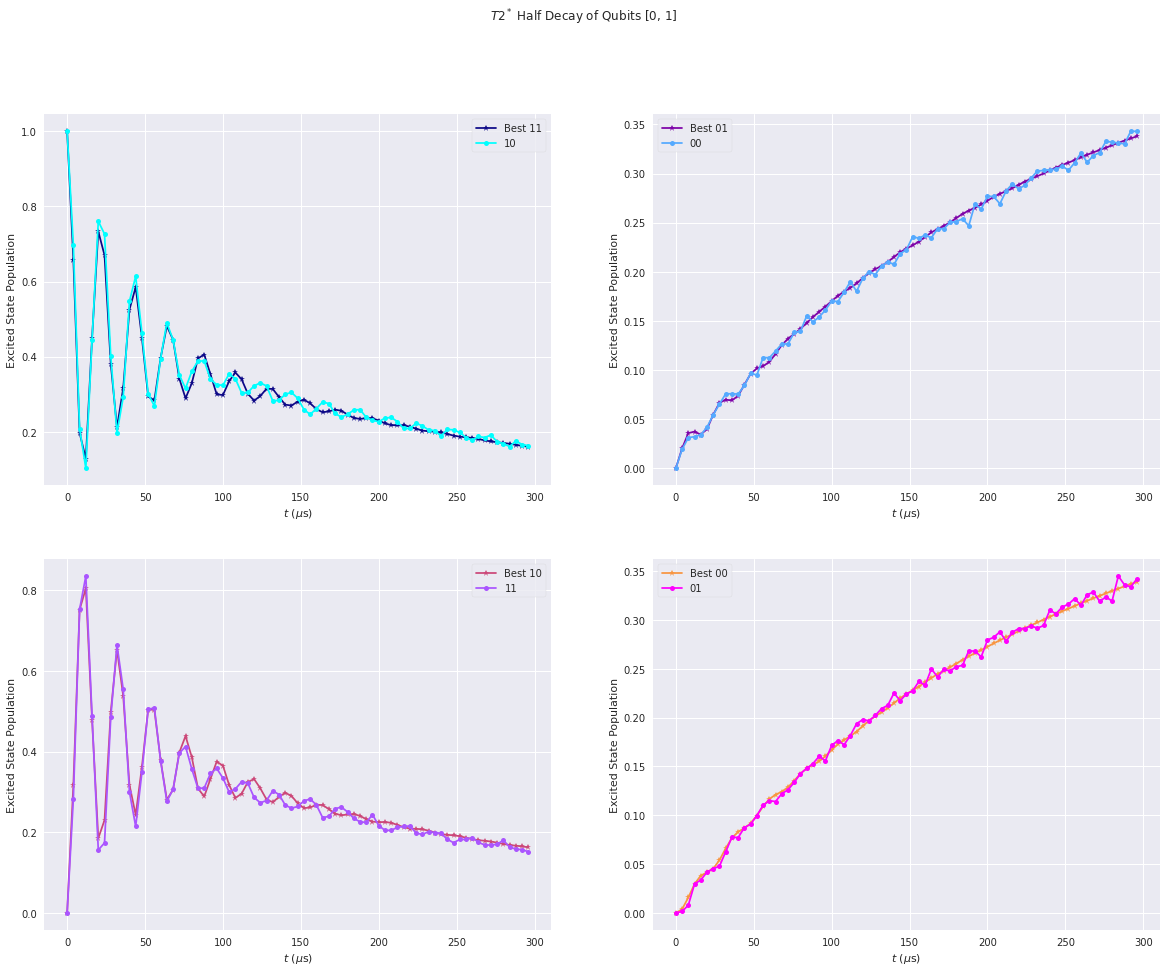

In [161]:
%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

# plt.errorbar(time, t2emit_lst00, t1ystd00, label = "00", marker='.', linestyle = '', markersize=10, c = cool[0])
# plt.errorbar(time, t2emit_lst10, t1ystd10, label = "10", marker='.', linestyle = '', markersize=10, c = cool[1])
# plt.errorbar(time, t2emit_lst01, t1ystd01, label = "01", marker='.', linestyle = '', markersize=10, c = cool[2])
# plt.errorbar(time, t2emit_lst11, t1ystd11, label = "11", marker='.', linestyle = '', markersize=10, c = cool[3])

# ax[0, 0].errorbar(time, t2emit_lst00, t1ystd00, label = "00", marker='.', linestyle = '', markersize=10, c = cool[0])
# ax[0, 1].errorbar(time, t2emit_lst10, t1ystd10, label = "10", marker='.', linestyle = '', markersize=10, c = cool[1])
# ax[1, 0].errorbar(time, t2emit_lst01, t1ystd01, label = "01", marker='.', linestyle = '', markersize=10, c = cool[2])
# ax[1, 1].errorbar(time, t2emit_lst11, t1ystd11, label = "11", marker='.', linestyle = '', markersize=10, c = cool[3])

# plt.plot(time, t2e_best[:, 0, 0], label = 'Best 00', marker='*', color = plasma[0])
# plt.plot(time, t2e_best[:, 1, 1], label = 'Best 10', marker='*', color = plasma[1])
# plt.plot(time, t2e_best[:, 2, 2], label = 'Best 01', marker='*', color = plasma[2])
# plt.plot(time, t2e_best[:, 3, 3], label = 'Best 11', marker='*', color = plasma[3])

ax[0, 0].plot(time, t2sh_best[:, 0, 0], label = 'Best 11', marker='*', color = plasma[0])
ax[0, 1].plot(time, t2sh_best[:, 1, 1], label = 'Best 01', marker='*', color = plasma[1])
ax[1, 0].plot(time, t2sh_best[:, 2, 2], label = 'Best 10', marker='*', color = plasma[2])
ax[1, 1].plot(time, t2sh_best[:, 3, 3], label = 'Best 00', marker='*', color = plasma[3])

ax[0, 0].plot(time, t2hmit_lst10, label = "10", marker='.', markersize=10, c = cool[0])
ax[0, 1].plot(time, t2hmit_lst00, label = "00", marker='.', markersize=10, c = cool[1])
ax[1, 0].plot(time, t2hmit_lst11, label = "11", marker='.', markersize=10, c = cool[2])
ax[1, 1].plot(time, t2hmit_lst01, label = "01", marker='.', markersize=10, c = cool[3])

fig.suptitle('$T2^*$ Half Decay of Qubits ' + str(qubits))

for a in ax.flat:
    a.set(xlabel='$t$ ($\mu$s)', ylabel='Excited State Population')

# Hide x labels and tick labels for top plots and y ticks for right plots.
# for b in ax.flat:
#     b.label_outer()

# fig.xlabel('$t$ ($\mu$s)')
# fig.ylabel('Excited State Population')
# plt.ylim(-0.05, 1.05)

ax[0, 0].legend(loc = "best",numpoints=1,frameon=True)
ax[0, 1].legend(loc = "best",numpoints=1,frameon=True)
ax[1, 0].legend(loc = "best",numpoints=1,frameon=True)
ax[1, 1].legend(loc = "best",numpoints=1,frameon=True)

plt.show()

In [207]:
# import csv

# rows_t2hx_00 = zip(time, t2sh_best[:, 0, 0])
# rows_t2hx_10 = zip(time, t2sh_best[:, 1, 1])
# rows_t2hx_01 = zip(time, t2sh_best[:, 2, 2])
# rows_t2hx_11 = zip(time, t2sh_best[:, 3, 3])

# with open('Q2_T2HX_best00.csv', "w") as a:
#     writer = csv.writer(a)
#     for row in rows_t2hx_00:
#         writer.writerow(row)

# with open('Q2_T2HX_best10.csv', "w") as a:
#     writer = csv.writer(a)
#     for row in rows_t2hx_10:
#         writer.writerow(row)

# with open('Q2_T2HX_best01.csv', "w") as a:
#     writer = csv.writer(a)
#     for row in rows_t2hx_01:
#         writer.writerow(row)

# with open('Q2_T2HX_best11.csv', "w") as a:
#     writer = csv.writer(a)
#     for row in rows_t2hx_11:
#         writer.writerow(row)

## Extract Parameters

In [162]:
best

DeviceArray([0.0000000e+00, 0.0000000e+00, 8.9590034e+00, 0.0000000e+00,
             0.0000000e+00, 4.0858719e+01, 5.8669643e+00, 6.5490708e+00,
             0.0000000e+00, 1.4443614e-01, 5.8669691e+00, 0.0000000e+00,
             0.0000000e+00, 0.0000000e+00, 4.9982950e-02, 1.2849794e+01,
             1.1288005e+01, 0.0000000e+00, 0.0000000e+00, 4.2808605e-03,
             3.4395047e-02], dtype=float32)

In [163]:
best[:3] * unts.GHz

<Quantity [0.      , 0.      , 8.959003] GHz>

In [164]:
jnp.average(best[:3]) * unts.GHz

<Quantity 2.9863346 GHz>

In [165]:
jnp.linalg.norm(best[:3]) * unts.GHz

<Quantity 8.959003 GHz>

In [166]:
w0 / 1e9 * unts.GHz

<Quantity 30.36827832 GHz>

In [167]:
best[3:6] * unts.GHz

<Quantity [ 0.     ,  0.     , 40.85872] GHz>

In [168]:
jnp.average(best[3:6]) * unts.GHz

<Quantity 13.619574 GHz>

In [169]:
jnp.linalg.norm(best[3:6]) * unts.GHz

<Quantity 40.85872 GHz>

In [170]:
w1 / 1e9 * unts.GHz

<Quantity 29.05374734 GHz>

In [171]:
best[6:15].reshape(3, 3)

DeviceArray([[5.8669643 , 6.549071  , 0.        ],
             [0.14443614, 5.866969  , 0.        ],
             [0.        , 0.        , 0.04998295]], dtype=float32)

In [172]:
jnp.linalg.norm(best[6:15])

DeviceArray(10.571485, dtype=float32)

In [173]:
jnp.linalg.det(best[6:15].reshape(3, 3))

DeviceArray(1.6731981, dtype=float32)

In [174]:
j01 * 1e-6

7.378105608801839

In [175]:
(1/best[15] * unts.ms).to(unts.us)

<Quantity 77.82226056 us>

In [176]:
(t1c[0] * unts.s).to(unts.us)

<Quantity 76.76192763 us>

In [177]:
(1/best[16] * unts.ms).to(unts.us)

<Quantity 88.58961612 us>

In [178]:
(t1c[1] * unts.s).to(unts.us)

<Quantity 174.25006081 us>

In [179]:
(1/best[17] * unts.ms).to(unts.us)

<Quantity inf us>

In [180]:
(1/best[18] * unts.ms).to(unts.us)

<Quantity inf us>

In [181]:
T(jnp.linalg.norm(best[:3]) * 1e9, best[19]).to(unts.mK)

<Quantity 12.53802609 mK>

In [182]:
T(jnp.linalg.norm(best[3:6]) * 1e9, best[20]).to(unts.mK)

<Quantity 91.69200808 mK>

In [183]:
best2

DeviceArray([3.0773613e+00, 5.7510094e+01, 1.2869824e+01, 9.9420462e+00,
             1.4988574e+01, 6.4786804e+01, 7.0020580e+00, 1.7797574e+00,
             1.2460487e+01, 1.0601529e+01, 6.3682561e+00, 7.0499603e+01,
             3.6338050e+00, 1.1166338e+01, 4.7021214e+01, 6.3410681e-04,
             3.9239616e+00, 1.7186420e+01, 0.0000000e+00, 6.5408802e-01,
             3.7564614e-16], dtype=float32)

In [184]:
best2[:3] * unts.GHz

<Quantity [ 3.0773613, 57.510094 , 12.869824 ] GHz>

In [185]:
jnp.average(best2[:3]) * unts.GHz

<Quantity 24.48576 GHz>

In [186]:
jnp.linalg.norm(best2[:3]) * unts.GHz

<Quantity 59.012825 GHz>

In [187]:
w0 / 1e9 * unts.GHz

<Quantity 30.36827832 GHz>

In [188]:
best2[3:6] * unts.GHz

<Quantity [ 9.942046, 14.988574, 64.786804] GHz>

In [189]:
jnp.average(best2[3:6]) * unts.GHz

<Quantity 29.905807 GHz>

In [190]:
jnp.linalg.norm(best2[3:6]) * unts.GHz

<Quantity 67.23713 GHz>

In [191]:
w1 / 1e9 * unts.GHz

<Quantity 29.05374734 GHz>

In [192]:
best2[6:15].reshape(3, 3)

DeviceArray([[ 7.002058 ,  1.7797574, 12.460487 ],
             [10.601529 ,  6.368256 , 70.4996   ],
             [ 3.633805 , 11.166338 , 47.021214 ]], dtype=float32)

In [193]:
jnp.linalg.norm(best2[6:15])

DeviceArray(87.63268, dtype=float32)

In [194]:
jnp.linalg.det(best2[6:15].reshape(3, 3))

DeviceArray(-2659.993, dtype=float32)

In [195]:
j01 * 1e-6

7.378105608801839

In [196]:
(1/best2[15] * unts.ms).to(unts.us)

<Quantity 1577021.36230469 us>

In [197]:
(t2c[0] * unts.s).to(unts.us)

<Quantity 118.11567674 us>

In [198]:
(1/best2[16] * unts.ms).to(unts.us)

<Quantity 254.84448671 us>

In [199]:
(t2c[1] * unts.s).to(unts.us)

<Quantity 98.02224668 us>

In [200]:
(1/best2[17] * unts.ms).to(unts.us)

<Quantity 58.18547308 us>

In [201]:
(1/best2[18] * unts.ms).to(unts.us)

<Quantity inf us>

In [202]:
T(jnp.linalg.norm(best2[:3]) * 1e9, best2[19]).to(unts.mK)

<Quantity 485.84991693 mK>

In [203]:
T(jnp.linalg.norm(best2[3:6]) * 1e9, best2[20]).to(unts.mK)

<Quantity 14.4595569 mK>

In [204]:
import qiskit.tools.jupyter
%qiskit_version_table